# Sales Forecasting of a Superstore using Time Series Models

# 1. Installing & Importing Packages

The below comments should be installed only for the first time

In [8]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#pip install plotly
#pip install prophet

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import random as rd
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

import pickle
import gc
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')



In [4]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [9]:
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from prophet import Prophet
from datetime import datetime


In [10]:
import statsmodels.api as sm
import pandas as pd
import plotly.express as px

# 2.  Reading the Input files

In [11]:
# specify datatypes before loading the data will save you a ton of memory.
dtypes = {'id': np.uint32,
          'store_nbr': np.uint8, 
          'item_nbr': np.uint32, 
          'unit_sales': np.float32,
          'class': np.uint16,
          'dcoilwtico':np.float16,
          'transactions':np.uint16,
          'cluster': np.uint32,
         'onpromotion' : 'object'}

In [12]:
df_train = pd.read_csv(r"C:\users\u2195687\Input\train.csv",parse_dates=['date'],dtype = {
                    'onpromotion': 'object'
               })


In [13]:
df_holiday =  pd.read_csv(r"C:\users\u2195687\Input\holidays_events.csv",parse_dates=['date'])
df_items =  pd.read_csv(r"C:\users\u2195687\Input\items.csv")
df_oil =  pd.read_csv(r"C:\users\u2195687\Input\oil.csv",parse_dates=['date'])
df_stores = pd.read_csv(r"C:\users\u2195687\Input\stores.csv")
df_transactions=pd.read_csv(r"C:\users\u2195687\Input\transactions.csv",parse_dates =['date'])

In [14]:
df_train['Year'] = pd.DatetimeIndex(df_train['date']).year #— to get the year from the date.
df_train['Month'] = pd.DatetimeIndex(df_train['date']).month # To get month from the date.
df_train['Day'] = pd.DatetimeIndex(df_train['date']).day # To get month from the date.

In [15]:
df_train.shape

(125497040, 9)

## 2.1) Samples of Each Dataframe

In [14]:
df_train.head()

id       date  store_nbr  item_nbr  unit_sales onpromotion  Year  Month  \
0   0 2013-01-01         25    103665         7.0         NaN  2013      1   
1   1 2013-01-01         25    105574         1.0         NaN  2013      1   
2   2 2013-01-01         25    105575         2.0         NaN  2013      1   
3   3 2013-01-01         25    108079         1.0         NaN  2013      1   
4   4 2013-01-01         25    108701         1.0         NaN  2013      1   

   Day  
0    1  
1    1  
2    1  
3    1  
4    1

In [15]:
df_train.describe()

id     store_nbr      item_nbr    unit_sales          Year  \
count  1.254970e+08  1.254970e+08  1.254970e+08  1.254970e+08  1.254970e+08   
mean   6.274852e+07  2.746458e+01  9.727692e+05  8.554865e+00  2.015223e+03   
std    3.622788e+07  1.633051e+01  5.205336e+05  2.360515e+01  1.299140e+00   
min    0.000000e+00  1.000000e+00  9.699500e+04 -1.537200e+04  2.013000e+03   
25%    3.137426e+07  1.200000e+01  5.223830e+05  2.000000e+00  2.014000e+03   
50%    6.274852e+07  2.800000e+01  9.595000e+05  4.000000e+00  2.015000e+03   
75%    9.412278e+07  4.300000e+01  1.354380e+06  9.000000e+00  2.016000e+03   
max    1.254970e+08  5.400000e+01  2.127114e+06  8.944000e+04  2.017000e+03   

              Month           Day  
count  1.254970e+08  1.254970e+08  
mean   6.334971e+00  1.560188e+01  
std    3.392866e+00  8.816411e+00  
min    1.000000e+00  1.000000e+00  
25%    3.000000e+00  8.000000e+00  
50%    6.000000e+00  1.500000e+01  
75%    9.000000e+00  2.300000e+01  
max    1.200000e+01  3.100000e+01

In [16]:
df_transactions.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

i) Transactions dataset has the store number and the transactions details.<br>
ii) We already know that Store number is also available in the train dataset as well.<br>
iii) Transactions denotes the total number of transactions happened on the particular day with respect to each store.

In [17]:
df_holiday.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [18]:
df_items.head()

item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1

i) Item dataset has the item number, family, class and perishable( likely to decay) <br>

In [19]:
df_oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [20]:
df_stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

Using the above details , we need to find the Unit_sales prediction for the future year <br>

## 2.2) More details of Dataframes

In [21]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
 6   Year         int64         
 7   Month        int64         
 8   Day          int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 8.4+ GB


In [22]:
df_train.shape

(125497040, 9)

It has 12 million records which is very huge. so, we can consider the sales only for some records.<br>
After visualisation , we can decide the factors to select records.


In [23]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [24]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [25]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [26]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [27]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


Date fields are of datetime type as we specify the dtype while importing. we can also create the day , month and year feature from the date feature

# 3) Visualisation of Each dataframes

## 3.1) Train

<AxesSubplot:xlabel='Year', ylabel='Unit Sales'>

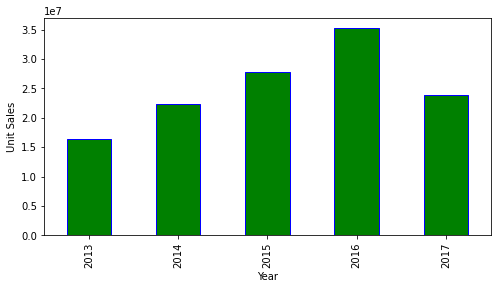

In [28]:
plt.figure(figsize=(8,4))
df_train['Year'].value_counts(sort = False).plot.bar(y=['unit_sales'],color=['green'],edgecolor='blue',xlabel='Year',
                                                     ylabel='Unit Sales')


2016 have the largest number of sales. 

<AxesSubplot:xlabel=' Month ', ylabel='Unit Sales'>

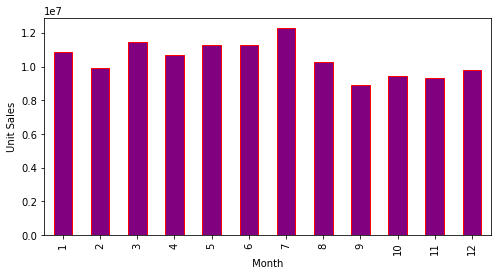

In [29]:
plt.figure(figsize=(8,4))
df_train['Month'].value_counts(sort = False).plot.bar(y=['unit_sales'],color=['Purple'],edgecolor='red',
                                                     xlabel = ' Month ',ylabel='Unit Sales')

The distributions are more or less equal with respect to the months

<AxesSubplot:xlabel=' Day ', ylabel='Unit Sales'>

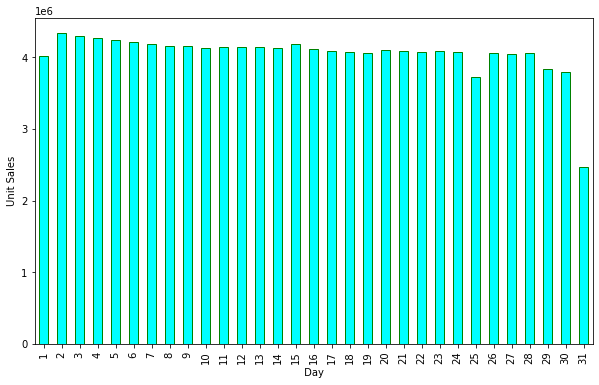

In [30]:
plt.figure(figsize=(10,6))
df_train['Day'].value_counts(sort = False).plot.bar(y=['unit_sales'],color=['cyan'],edgecolor='green',
                                                   xlabel = ' Day ',ylabel='Unit Sales')

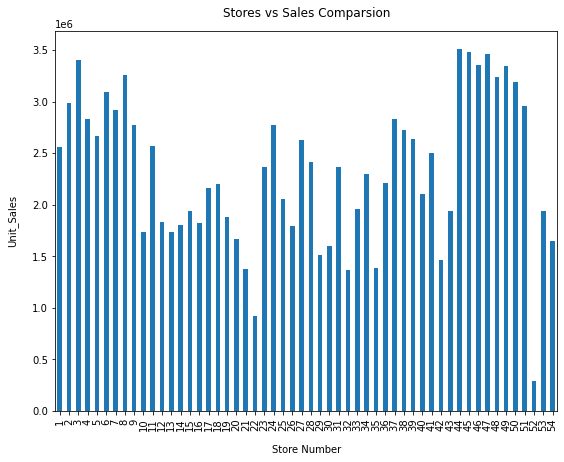

In [31]:
plt.figure(figsize=(20,8))
df_train['store_nbr'].sort_values().value_counts(sort = False).plot.bar(figsize=(9, 7))
#value_counts sorts the values by descending frequencies by default. Disable sorting using sort=False:
plt.xlabel("Store Number", labelpad=14)
plt.ylabel("Unit_Sales", labelpad=14)
plt.title("Stores vs Sales Comparsion", y=1.02);

<AxesSubplot:>

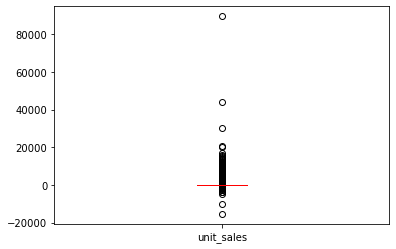

In [32]:
df_train.boxplot(column =['unit_sales'], grid = False,color='red')

<AxesSubplot:xlabel='onpromotion', ylabel='count'>

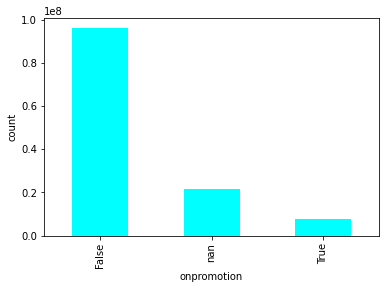

In [33]:
df_train['onpromotion'].value_counts(dropna=False).plot.bar(color='aqua',xlabel='onpromotion',ylabel='count')

## 3.2) Transactions

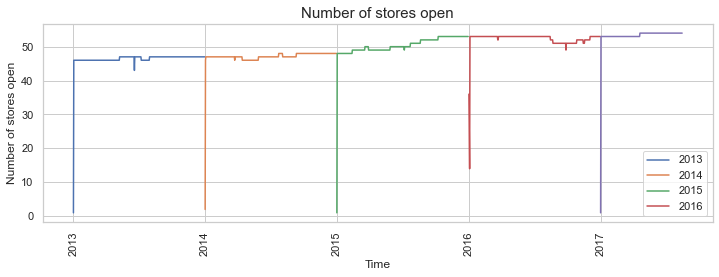

In [34]:
#transactions
# month over month sales
df_transactions['date']=pd.to_datetime(df_transactions['date'])
temp=df_transactions.groupby(['date']).aggregate({'store_nbr':'count','transactions':np.sum})
temp=temp.reset_index()
temp_2013=temp[temp['date'].dt.year==2013].reset_index(drop=True)
temp_2014=temp[temp['date'].dt.year==2014].reset_index(drop=True)
temp_2015=temp[temp['date'].dt.year==2015].reset_index(drop=True)
temp_2016=temp[temp['date'].dt.year==2016].reset_index(drop=True)
temp_2017=temp[temp['date'].dt.year==2017].reset_index(drop=True)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(temp_2013['date'],temp_2013.iloc[:,1],label="2013")
plt.plot(temp_2014['date'],temp_2014.iloc[:,1],label="2014")
plt.plot(temp_2015['date'],temp_2015.iloc[:,1],label="2015")
plt.plot(temp_2016['date'],temp_2016.iloc[:,1],label="2016")
plt.plot(temp_2017['date'],temp_2017.iloc[:,1],label="2017")
plt.ylabel('Number of stores open', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Number of stores open', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(['2013', '2014', '2015', '2016'], loc='lower right')

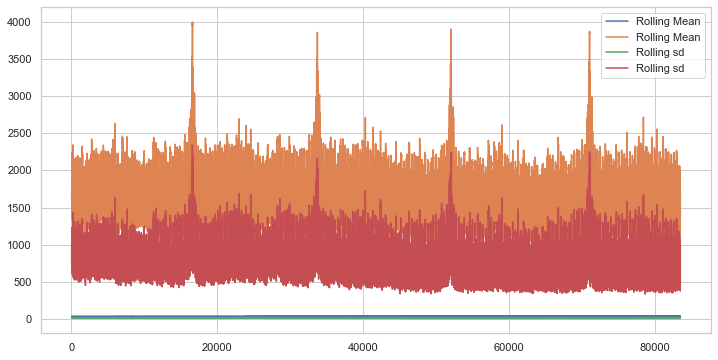

In [35]:
plt.figure(figsize=(12,6))
plt.plot(df_transactions.rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(df_transactions.rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();

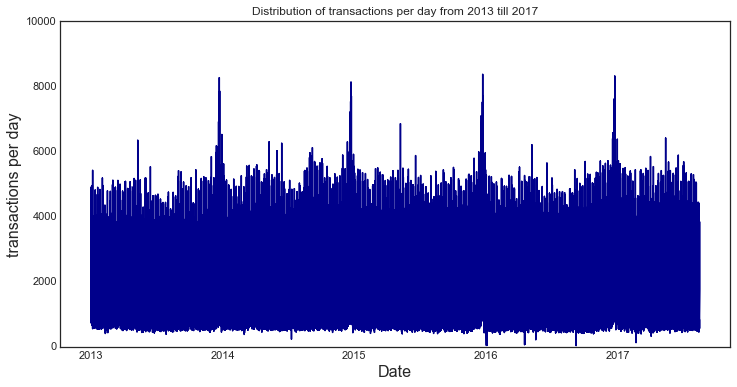

In [36]:
plt.style.use('seaborn-white')
plt.figure(figsize=(12,6))
plt.plot(df_transactions.date.values, df_transactions.transactions.values, color='darkblue')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()

## 3.3) Items

<AxesSubplot:xlabel='Perishable Items', ylabel='count'>

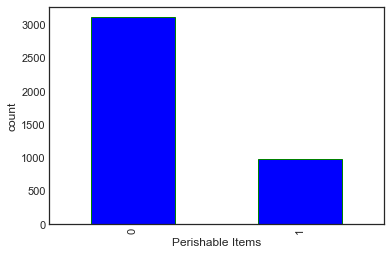

In [37]:
df_items['perishable'].value_counts(sort = False).plot.bar(color=['blue'],edgecolor='green',
                                                           xlabel='Perishable Items',ylabel='count')

<AxesSubplot:xlabel='Item Family', ylabel='count'>

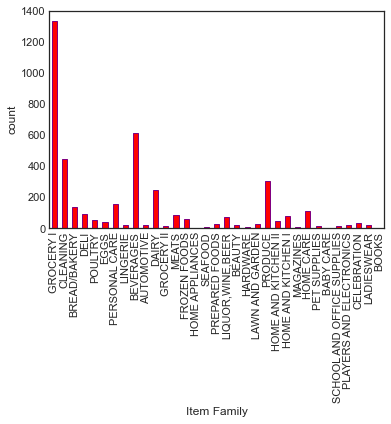

In [38]:
figsize=(24,40)
df_items['family'].value_counts(sort = False).plot.bar(color=['red'],edgecolor='purple',
                                                       xlabel='Item Family',ylabel='count')

## 3.4) Stores

In [39]:
 plt.style.use('seaborn-white')
 nbr_cluster = df_stores.groupby(['store_nbr','cluster']).size()
 nbr_cluster.unstack().iloc[neworder].plot(kind='bar',stacked=True, colormap= 'tab20', figsize=(16,5),  grid=False)
 plt.title('Store numbers and the clusters they are assigned to', fontsize=14)
 plt.ylabel('Clusters')
 plt.xlabel('Store number')
 plt.show()

NameError: name 'neworder' is not defined

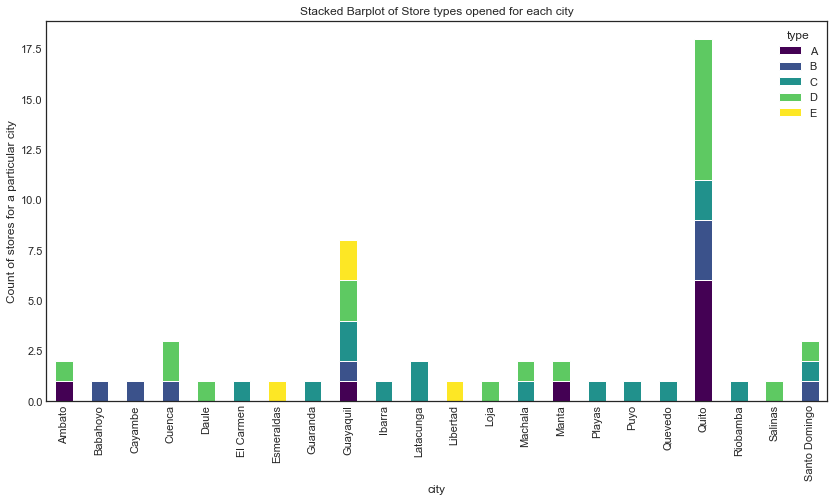

In [40]:
plt.style.use('seaborn-white')
city_cluster = df_stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(14,7),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

## 3.5) Oil

In [41]:
#df_oil['Year'] = pd.DatetimeIndex(df_oil['date']).year #— to get the year from the date.
#df_oil['Month'] = pd.DatetimeIndex(df_oil['date']).month # To get month from the date.
#df_oil['Day'] = pd.DatetimeIndex(df_oil['date']).day # To get month from the date.

In [513]:
 trace = go.Scatter(
     name='Oil prices',
     x=df_oil['date'],
     y=df_oil['dcoilwtico'].dropna(),
     mode='lines',
     line=dict(color='rgb(25, 15, 200, 0.5)'),
     #fillcolor='rgba(68, 68, 68, 0.3)',
     fillcolor='rgba(0, 1, 219, 0.4)',
     fill='tonexty' )

 data = [trace]

 layout = go.Layout(
     yaxis=dict(title='Daily Oil price'),
     title='Daily oil prices from Jan 2013 till July 2017',
     showlegend = False)
 fig = go.Figure(data=data, layout=layout)
 py.iplot(fig, filename='pandas-time-series-error-bars')

## 3.6) Holiday

In [43]:
#df_holiday['Year'] = pd.DatetimeIndex(df_holiday['date']).year #— to get the year from the date.
#df_holiday['Month'] = pd.DatetimeIndex(df_holiday['date']).month # To get month from the date.
#df_holiday['Day'] = pd.DatetimeIndex(df_holiday['date']).day # To get month from the date.

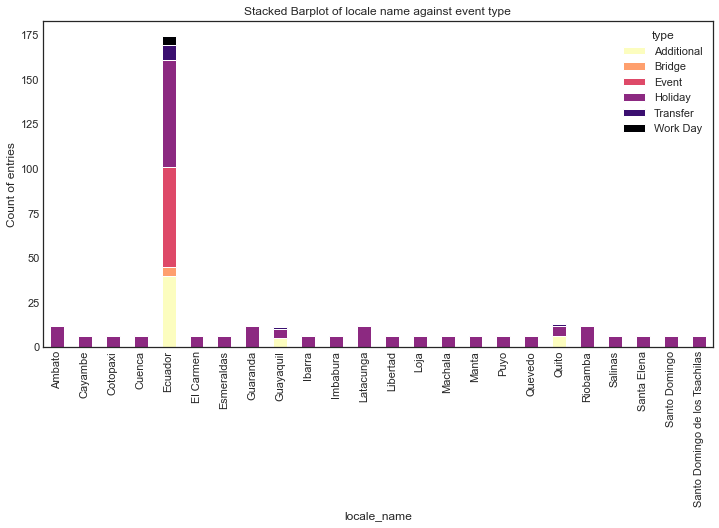

In [44]:
plt.style.use('seaborn-white')
holiday_local_type = df_holiday.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,6),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

# 4) Creating new Dataframe with filtered data

Lets Extract 3 years data and keep it in a dataframe and save it in a csv

In [16]:
year_nbr = [2015,2016,2017]
df_trainyr = df_train[df_train['Year'].isin(year_nbr)]
print(df_trainyr.shape)

(86902776, 9)


####  Year Dataframe

In [17]:
print(df_train.shape)

(125497040, 9)


## 4.1) Filtering based on conditions


In [18]:
df_trainyr.head()

id       date  store_nbr  item_nbr  unit_sales onpromotion  \
38594264  38594264 2015-01-01         25    103665        12.0       False   
38594265  38594265 2015-01-01         25    105575        23.0       False   
38594266  38594266 2015-01-01         25    108634         1.0       False   
38594267  38594267 2015-01-01         25    108698         6.0       False   
38594268  38594268 2015-01-01         25    108786         6.0       False   

          Year  Month  Day  
38594264  2015      1    1  
38594265  2015      1    1  
38594266  2015      1    1  
38594267  2015      1    1  
38594268  2015      1    1

In [19]:
item_num = df_items.loc[df_items['family']=='EGGS']['item_nbr'].tolist()
print(item_num)

[108833, 127547, 158680, 208384, 208386, 227111, 258268, 357961, 357962, 357963, 376427, 407499, 407500, 457424, 457425, 476261, 507478, 507479, 525902, 557256, 557257, 575875, 575876, 617092, 617096, 617103, 617113, 679926, 902198, 902200, 902202, 1082907, 1089163, 1148548, 1162755, 1162759, 1167614, 1259006, 1259007, 1320701, 1974848]


####  Egg Dataframe

In [20]:
df_egg = df_trainyr[df_trainyr['item_nbr'].isin(item_num)]

In [21]:
print(df_egg.shape)

(967504, 9)


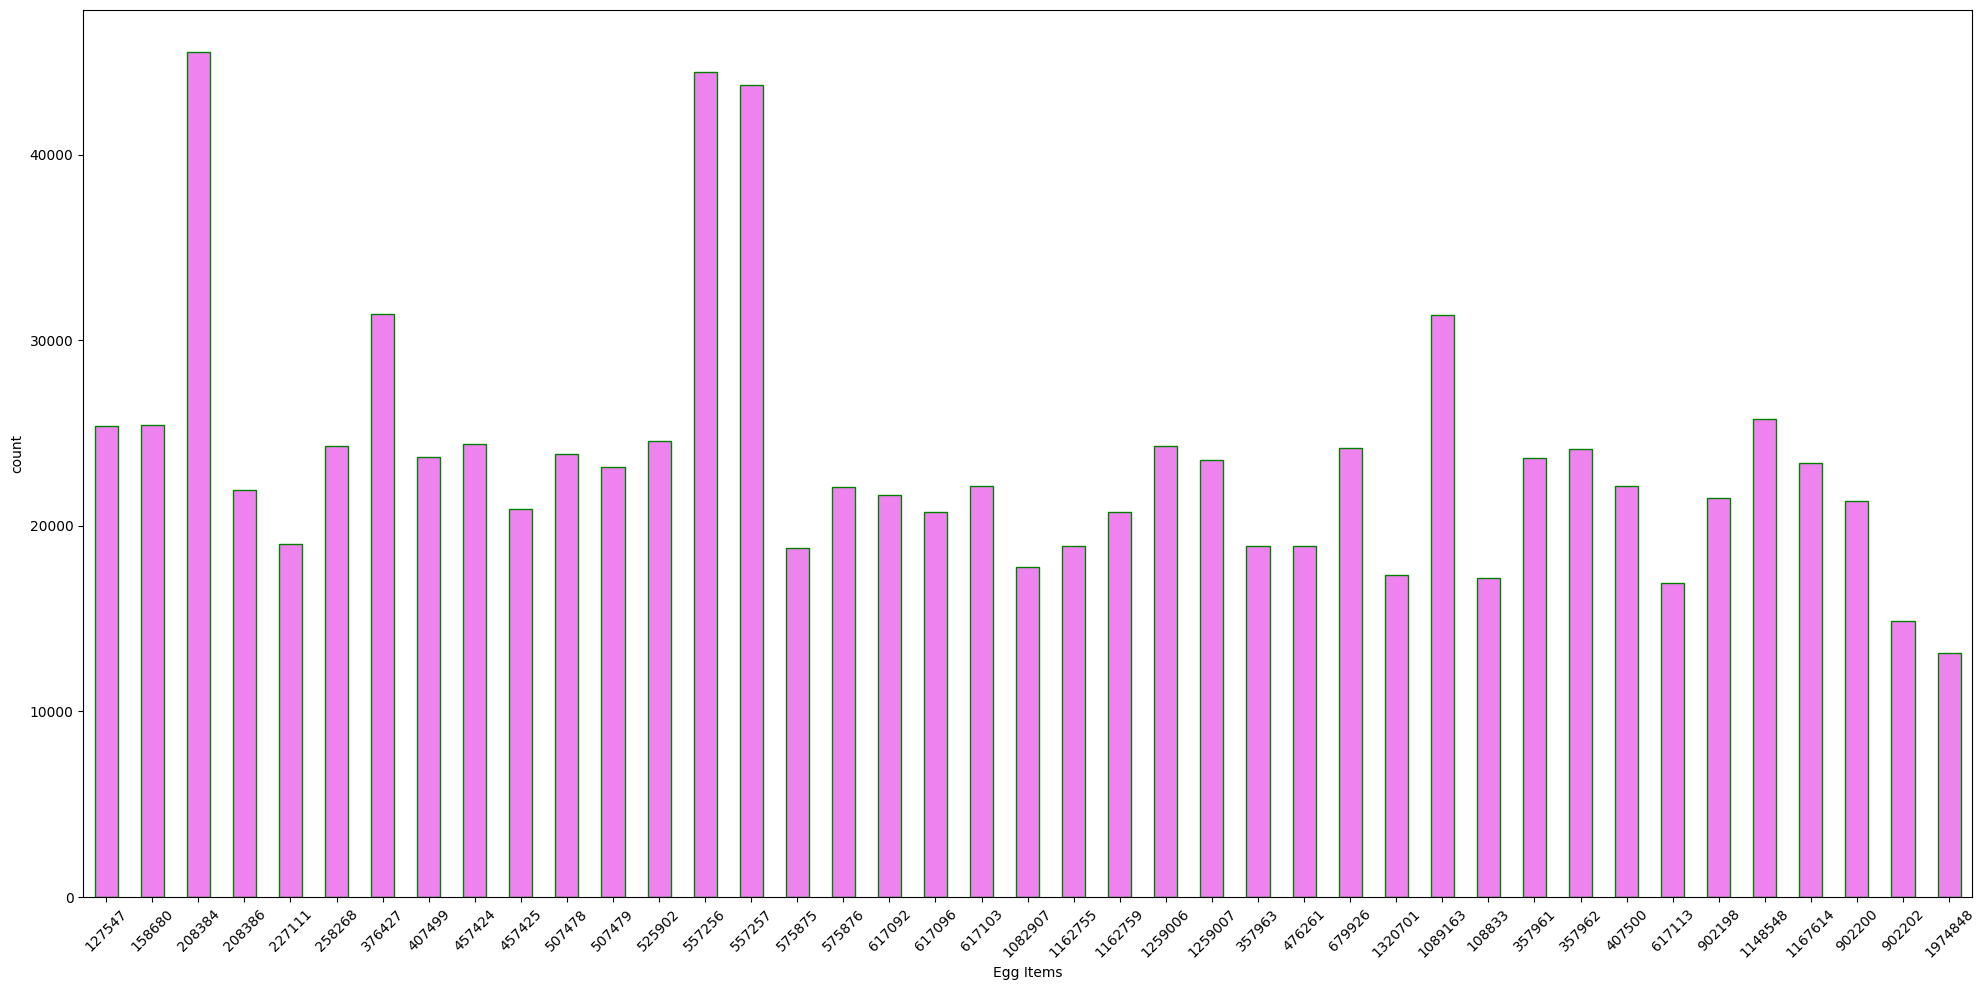

In [22]:
df_egg['item_nbr'].value_counts(sort = False).plot.bar(color=['violet'],edgecolor='green',
                                                           xlabel='Egg Items',ylabel='count',figsize = (20,10))
plt.xticks(rotation=45)
plt.tight_layout()

In [23]:
df_eggmin = df_egg[df_egg['item_nbr']==1974848]
df_eggmax = df_egg[df_egg['item_nbr']==208384]

In [24]:
print(df_eggmin.shape)
print(df_eggmax.shape)

(13166, 9)
(45526, 9)


so let us proceed with the dataframe df_eggmin

In [25]:
df_eggmax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45526 entries, 38594342 to 125493975
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           45526 non-null  int64         
 1   date         45526 non-null  datetime64[ns]
 2   store_nbr    45526 non-null  int64         
 3   item_nbr     45526 non-null  int64         
 4   unit_sales   45526 non-null  float64       
 5   onpromotion  45526 non-null  object        
 6   Year         45526 non-null  int64         
 7   Month        45526 non-null  int64         
 8   Day          45526 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 3.5+ MB


In [26]:
df_eggmax.head()

id       date  store_nbr  item_nbr  unit_sales onpromotion  \
38594342  38594342 2015-01-01         25    208384        37.0       False   
38595506  38595506 2015-01-02          1    208384        27.0        True   
38596664  38596664 2015-01-02          2    208384        22.0        True   
38598159  38598159 2015-01-02          3    208384        92.0        True   
38599830  38599830 2015-01-02          4    208384        14.0        True   

          Year  Month  Day  
38594342  2015      1    1  
38595506  2015      1    2  
38596664  2015      1    2  
38598159  2015      1    2  
38599830  2015      1    2

<AxesSubplot:>

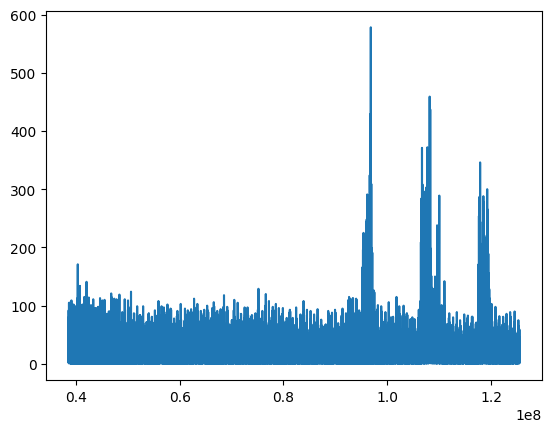

In [27]:
df_eggmax['unit_sales'].plot()

## 4.2) Merging with other Dataframes

In [28]:
# Left Join - Train & Items 
train_subset = pd.merge(df_eggmax, df_items, on = 'item_nbr', how = 'left')
train_subset.head()

id       date  store_nbr  item_nbr  unit_sales onpromotion  Year  \
0  38594342 2015-01-01         25    208384        37.0       False  2015   
1  38595506 2015-01-02          1    208384        27.0        True  2015   
2  38596664 2015-01-02          2    208384        22.0        True  2015   
3  38598159 2015-01-02          3    208384        92.0        True  2015   
4  38599830 2015-01-02          4    208384        14.0        True  2015   

   Month  Day family  class  perishable  
0      1    1   EGGS   2502           1  
1      1    2   EGGS   2502           1  
2      1    2   EGGS   2502           1  
3      1    2   EGGS   2502           1  
4      1    2   EGGS   2502           1

In [29]:
# Left Join - merged & Store 
train_subset = pd.merge(train_subset, df_stores, on = 'store_nbr', how = 'left')
train_subset.head()

id       date  store_nbr  item_nbr  unit_sales onpromotion  Year  \
0  38594342 2015-01-01         25    208384        37.0       False  2015   
1  38595506 2015-01-02          1    208384        27.0        True  2015   
2  38596664 2015-01-02          2    208384        22.0        True  2015   
3  38598159 2015-01-02          3    208384        92.0        True  2015   
4  38599830 2015-01-02          4    208384        14.0        True  2015   

   Month  Day family  class  perishable     city        state type  cluster  
0      1    1   EGGS   2502           1  Salinas  Santa Elena    D        1  
1      1    2   EGGS   2502           1    Quito    Pichincha    D       13  
2      1    2   EGGS   2502           1    Quito    Pichincha    D       13  
3      1    2   EGGS   2502           1    Quito    Pichincha    D        8  
4      1    2   EGGS   2502           1    Quito    Pichincha    D        9

In [30]:
# Left Join - merged & Oil
train_subset = pd.merge(train_subset, df_oil, on = 'date', how = 'left')
train_subset.head()

id       date  store_nbr  item_nbr  unit_sales onpromotion  Year  \
0  38594342 2015-01-01         25    208384        37.0       False  2015   
1  38595506 2015-01-02          1    208384        27.0        True  2015   
2  38596664 2015-01-02          2    208384        22.0        True  2015   
3  38598159 2015-01-02          3    208384        92.0        True  2015   
4  38599830 2015-01-02          4    208384        14.0        True  2015   

   Month  Day family  class  perishable     city        state type  cluster  \
0      1    1   EGGS   2502           1  Salinas  Santa Elena    D        1   
1      1    2   EGGS   2502           1    Quito    Pichincha    D       13   
2      1    2   EGGS   2502           1    Quito    Pichincha    D       13   
3      1    2   EGGS   2502           1    Quito    Pichincha    D        8   
4      1    2   EGGS   2502           1    Quito    Pichincha    D        9   

   dcoilwtico  
0         NaN  
1       52.72  
2       52.72  
3       52.72  
4       52.72

In [31]:
# Left Join - Train & Holiday
train_subset = pd.merge(train_subset, df_holiday, on = 'date', how = 'left')
train_subset.head()

id       date  store_nbr  item_nbr  unit_sales onpromotion  Year  \
0  38594342 2015-01-01         25    208384        37.0       False  2015   
1  38595506 2015-01-02          1    208384        27.0        True  2015   
2  38596664 2015-01-02          2    208384        22.0        True  2015   
3  38598159 2015-01-02          3    208384        92.0        True  2015   
4  38599830 2015-01-02          4    208384        14.0        True  2015   

   Month  Day family  ...     city        state type_x cluster dcoilwtico  \
0      1    1   EGGS  ...  Salinas  Santa Elena      D       1        NaN   
1      1    2   EGGS  ...    Quito    Pichincha      D      13      52.72   
2      1    2   EGGS  ...    Quito    Pichincha      D      13      52.72   
3      1    2   EGGS  ...    Quito    Pichincha      D       8      52.72   
4      1    2   EGGS  ...    Quito    Pichincha      D       9      52.72   

    type_y    locale locale_name                description transferred  
0  Holiday  National     Ecuador         Primer dia del ano       False  
1   Bridge  National     Ecuador  Puente Primer dia del ano       False  
2   Bridge  National     Ecuador  Puente Primer dia del ano       False  
3   Bridge  National     Ecuador  Puente Primer dia del ano       False  
4   Bridge  National     Ecuador  Puente Primer dia del ano       False  

[5 rows x 22 columns]

In [32]:
train_subset.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'Year', 'Month', 'Day', 'family', 'class', 'perishable', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name', 'description', 'transferred'],
      dtype='object')

In [33]:
train_subset = train_subset.drop(['locale', 'locale_name','description','transferred'], axis=1)


In [34]:
train_subset = train_subset.rename(columns={"type_y": "day_type", "type_x": "type","dcoilwtico":"oil_price"})

In [35]:
train_subset.describe()

id     store_nbr  item_nbr    unit_sales          Year  \
count  4.645800e+04  46458.000000   46458.0  46458.000000  46458.000000   
mean   7.927775e+07     27.347045  208384.0     15.937557   2015.879762   
std    2.566524e+07     15.696945       0.0     20.012322      0.774293   
min    3.859434e+07      1.000000  208384.0      1.000000   2015.000000   
25%    5.617923e+07     14.000000  208384.0      4.000000   2015.000000   
50%    7.832521e+07     28.000000  208384.0      9.000000   2016.000000   
75%    1.013656e+08     41.000000  208384.0     21.000000   2016.000000   
max    1.254940e+08     54.000000  208384.0    578.000000   2017.000000   

              Month           Day    class  perishable       cluster  \
count  46458.000000  46458.000000  46458.0     46458.0  46458.000000   
mean       6.010052     15.632636   2502.0         1.0      8.479121   
std        3.301916      8.799233      0.0         0.0      4.623320   
min        1.000000      1.000000   2502.0         1.0      1.000000   
25%        3.000000      8.000000   2502.0         1.0      4.000000   
50%        6.000000     15.000000   2502.0         1.0      9.000000   
75%        9.000000     23.000000   2502.0         1.0     13.000000   
max       12.000000     31.000000   2502.0         1.0     17.000000   

          oil_price  
count  31363.000000  
mean      46.738771  
std        6.728534  
min       26.190000  
25%       43.870000  
50%       47.280000  
75%       50.610000  
max       61.360000

In [36]:
train_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46458 entries, 0 to 46457
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           46458 non-null  int64         
 1   date         46458 non-null  datetime64[ns]
 2   store_nbr    46458 non-null  int64         
 3   item_nbr     46458 non-null  int64         
 4   unit_sales   46458 non-null  float64       
 5   onpromotion  46458 non-null  object        
 6   Year         46458 non-null  int64         
 7   Month        46458 non-null  int64         
 8   Day          46458 non-null  int64         
 9   family       46458 non-null  object        
 10  class        46458 non-null  int64         
 11  perishable   46458 non-null  int64         
 12  city         46458 non-null  object        
 13  state        46458 non-null  object        
 14  type         46458 non-null  object        
 15  cluster      46458 non-null  int64         
 16  oil_

In [37]:
train_subset

id       date  store_nbr  item_nbr  unit_sales onpromotion  \
0       38594342 2015-01-01         25    208384        37.0       False   
1       38595506 2015-01-02          1    208384        27.0        True   
2       38596664 2015-01-02          2    208384        22.0        True   
3       38598159 2015-01-02          3    208384        92.0        True   
4       38599830 2015-01-02          4    208384        14.0        True   
...          ...        ...        ...       ...         ...         ...   
46453  125484394 2017-08-15         49    208384        26.0       False   
46454  125487020 2017-08-15         50    208384         2.0       False   
46455  125489400 2017-08-15         51    208384        28.0       False   
46456  125491619 2017-08-15         52    208384        28.0       False   
46457  125493975 2017-08-15         53    208384         8.0       False   

       Year  Month  Day family  class  perishable       city        state  \
0      2015      1    1   EGGS   2502           1    Salinas  Santa Elena   
1      2015      1    2   EGGS   2502           1      Quito    Pichincha   
2      2015      1    2   EGGS   2502           1      Quito    Pichincha   
3      2015      1    2   EGGS   2502           1      Quito    Pichincha   
4      2015      1    2   EGGS   2502           1      Quito    Pichincha   
...     ...    ...  ...    ...    ...         ...        ...          ...   
46453  2017      8   15   EGGS   2502           1      Quito    Pichincha   
46454  2017      8   15   EGGS   2502           1     Ambato   Tungurahua   
46455  2017      8   15   EGGS   2502           1  Guayaquil       Guayas   
46456  2017      8   15   EGGS   2502           1      Manta       Manabi   
46457  2017      8   15   EGGS   2502           1      Manta       Manabi   

      type  cluster  oil_price day_type  
0        D        1        NaN  Holiday  
1        D       13      52.72   Bridge  
2        D       13      52.72   Bridge  
3        D        8      52.72   Bridge  
4        D        9      52.72   Bridge  
...    ...      ...        ...      ...  
46453    A       11      47.57  Holiday  
46454    A       14      47.57  Holiday  
46455    A       17      47.57  Holiday  
46456    A       11      47.57  Holiday  
46457    D       13      47.57  Holiday  

[46458 rows x 18 columns]

In [38]:
train_subsetbkp = train_subset.copy()

In [39]:
train_subset = train_subset.set_index('date')

## 4.3) Resampling to Business days

In [40]:
train_subset_d = train_subset.resample('B').mean()
train_subset_d.shape


(684, 11)

In [41]:
train_subset_with = train_subset.resample('D').mean()
train_subset_with.shape
#Daily - with holidays- facing lot of Nans

(958, 11)

In [42]:
train_subset_dbkp = train_subset_d.copy()
#Back up in another dataframe 

In [43]:
train_subset_d

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-01  3.859434e+07  25.000000  208384.0   37.000000  2015.0    1.0   
2015-01-02  3.868373e+07  26.661417  208384.0   25.283465  2015.0    1.0   
2015-01-05  3.880926e+07  28.600000  208384.0   23.875000  2015.0    1.0   
2015-01-06  3.886649e+07  27.452381  208384.0   17.809524  2015.0    1.0   
2015-01-07  3.892401e+07  27.139535  208384.0   17.488372  2015.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.613636  2017.0    8.0   

                  Day   class  perishable   cluster  oil_price  
date                                                            
2015-01-01   1.000000  2502.0         1.0  1.000000        NaN  
2015-01-02   2.968504  2502.0         1.0  8.881890      52.72  
2015-01-05   5.000000  2502.0         1.0  8.325000      50.05  
2015-01-06   6.000000  2502.0         1.0  8.476190      47.98  
2015-01-07   7.000000  2502.0         1.0  8.488372      48.69  
...               ...     ...         ...       ...        ...  
2017-08-09   9.000000  2502.0         1.0  8.326087      49.59  
2017-08-10  10.000000  2502.0         1.0  8.274510      48.54  
2017-08-11  11.993103  2502.0         1.0  8.324138      48.81  
2017-08-14  14.000000  2502.0         1.0  8.591837      47.59  
2017-08-15  15.000000  2502.0         1.0  8.750000      47.57  

[684 rows x 11 columns]

# 5) Exploratory Data Analysis

Basic Analysis

In [44]:
print("Rows :",train_subset_d.shape[0])
print("Columns :",train_subset_d.shape[1])
print("\n Features :",train_subset_d.columns.tolist())
print("\n Missing Values :",train_subset_d.isnull().sum())
print("\n Unique Values :",train_subset_d.nunique()) 


Rows : 684
Columns : 11

 Features : ['id', 'store_nbr', 'item_nbr', 'unit_sales', 'Year', 'Month', 'Day', 'class', 'perishable', 'cluster', 'oil_price']

 Missing Values : id             0
store_nbr      0
item_nbr       0
unit_sales     0
Year           0
Month          0
Day            0
class          0
perishable     0
cluster        0
oil_price     25
dtype: int64

 Unique Values : id            684
store_nbr     515
item_nbr        1
unit_sales    628
Year            4
Month          21
Day           154
class           1
perishable      1
cluster       376
oil_price     576
dtype: int64


Its evident that the column item_nbr ,family , class and perishable have only one value so we can drop them. Also, the missing values are available in the fields oil_price and day_type


Indexing - this allows Querying of the date easily and also data retrieval works fine here.At the same time, time series needs date as the index

Querying the date (We can pass the indexed value in the loc function for effective querying)

In [45]:
train_subset_d.loc['2017']

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2017-01-02  1.017459e+08  27.440000  208384.0   22.420000  2017.0    1.0   
2017-01-03  1.018579e+08  27.125000  208384.0   18.500000  2017.0    1.0   
2017-01-04  1.019669e+08  27.500000  208384.0   14.600000  2017.0    1.0   
2017-01-05  1.020727e+08  28.276596  208384.0   12.361702  2017.0    1.0   
2017-01-06  1.022850e+08  27.225166  208384.0   15.483444  2017.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.613636  2017.0    8.0   

                  Day   class  perishable   cluster  oil_price  
date                                                            
2017-01-02   2.000000  2502.0         1.0  8.520000        NaN  
2017-01-03   3.000000  2502.0         1.0  8.750000      52.36  
2017-01-04   4.000000  2502.0         1.0  8.520000      53.26  
2017-01-05   5.000000  2502.0         1.0  8.468085      53.77  
2017-01-06   7.033113  2502.0         1.0  8.437086      53.98  
...               ...     ...         ...       ...        ...  
2017-08-09   9.000000  2502.0         1.0  8.326087      49.59  
2017-08-10  10.000000  2502.0         1.0  8.274510      48.54  
2017-08-11  11.993103  2502.0         1.0  8.324138      48.81  
2017-08-14  14.000000  2502.0         1.0  8.591837      47.59  
2017-08-15  15.000000  2502.0         1.0  8.750000      47.57  

[162 rows x 11 columns]

In [46]:
train_subset_d.loc['2016':'2017']

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2016-01-01  6.656135e+07  26.960000  208384.0   21.360000  2016.0    1.0   
2016-01-04  6.670822e+07  26.775510  208384.0   19.551020  2016.0    1.0   
2016-01-05  6.680518e+07  27.666667  208384.0   15.755556  2016.0    1.0   
2016-01-06  6.689838e+07  27.100000  208384.0   14.140000  2016.0    1.0   
2016-01-07  6.699207e+07  28.204545  208384.0   11.545455  2016.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.613636  2017.0    8.0   

                  Day   class  perishable   cluster  oil_price  
date                                                            
2016-01-01   2.520000  2502.0         1.0  8.480000        NaN  
2016-01-04   4.000000  2502.0         1.0  8.285714      36.81  
2016-01-05   5.000000  2502.0         1.0  7.822222      35.97  
2016-01-06   6.000000  2502.0         1.0  8.680000      33.97  
2016-01-07   7.000000  2502.0         1.0  8.545455      33.29  
...               ...     ...         ...       ...        ...  
2017-08-09   9.000000  2502.0         1.0  8.326087      49.59  
2017-08-10  10.000000  2502.0         1.0  8.274510      48.54  
2017-08-11  11.993103  2502.0         1.0  8.324138      48.81  
2017-08-14  14.000000  2502.0         1.0  8.591837      47.59  
2017-08-15  15.000000  2502.0         1.0  8.750000      47.57  

[423 rows x 11 columns]

## 5.1 Plotting the Variables

In [47]:
train_subset_data = train_subset_d['unit_sales']
train_subset_data.head()

date
2015-01-01    37.000000
2015-01-02    25.283465
2015-01-05    23.875000
2015-01-06    17.809524
2015-01-07    17.488372
Freq: B, Name: unit_sales, dtype: float64

<AxesSubplot:xlabel='Date', ylabel='Unit_Sales'>

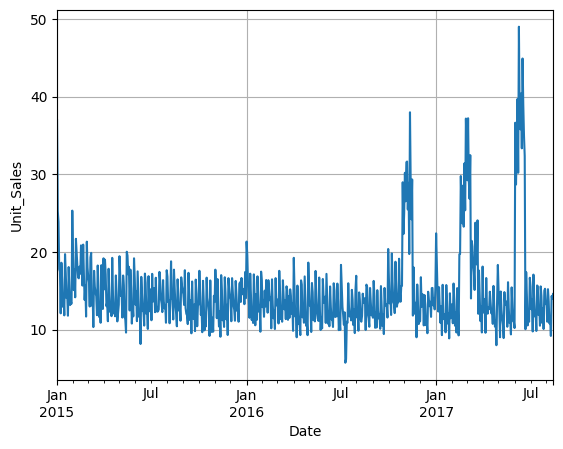

In [48]:
train_subset_data.plot(grid=True,xlabel='Date',ylabel='Unit_Sales')


Year 2015 Plot

<AxesSubplot:xlabel='date'>

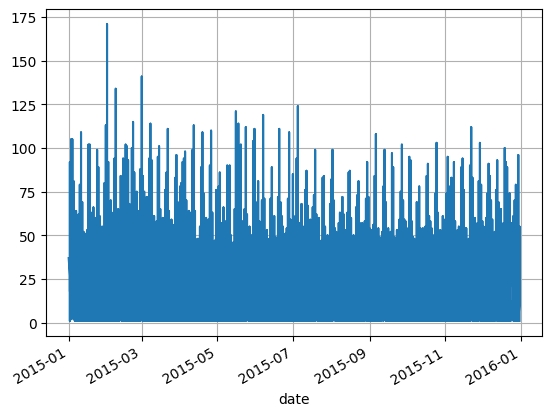

In [49]:
train_2015 = train_subset['2015']
sales_train_2015 = train_2015['unit_sales']
sales_train_2015.plot(grid=True)

Year 2016 Plot

<AxesSubplot:xlabel='date'>

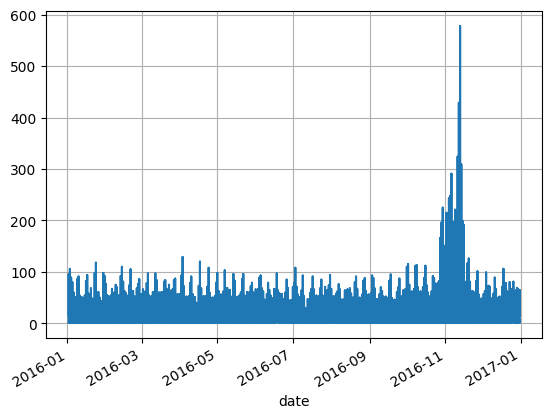

In [50]:
train_2016 = train_subset['2016']
sales_train_2016 = train_2016['unit_sales']
sales_train_2016.plot(grid=True)

Year 2017 Plot

<AxesSubplot:xlabel='date'>

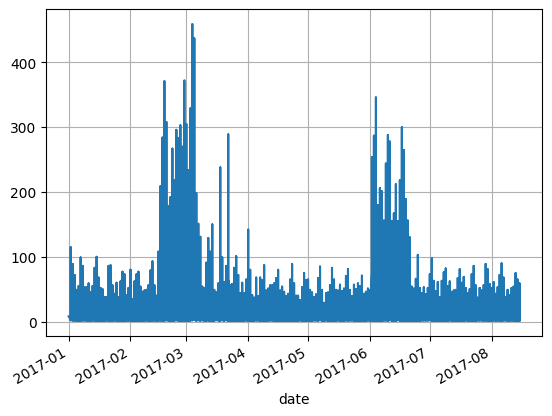

In [51]:
train_2017 = train_subset['2017']
sales_train_2017 = train_2017['unit_sales']
sales_train_2017.plot(grid=True)

Histogram

array([[<AxesSubplot:title={'center':'unit_sales'}>]], dtype=object)

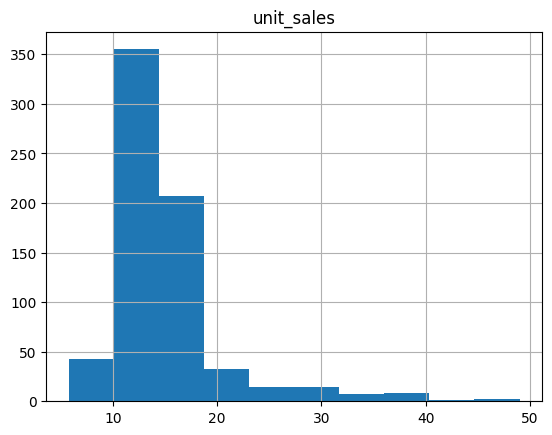

In [52]:
train_subset_d[['unit_sales']].hist()

<AxesSubplot:ylabel='Density'>

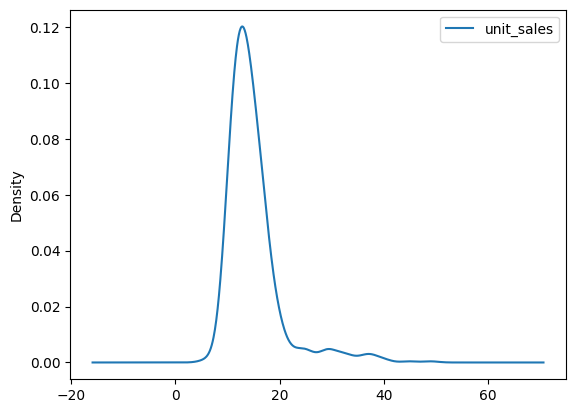

In [53]:
train_subset_d[['unit_sales']].plot(kind='density')

Lag Plot:
      They will show the relationship between the current period and the lag period. Linear shape suggest that a Autoregressive can be applied. This is used to check linearity , randomness , Outliers and check autocorrelation as well

First Order

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

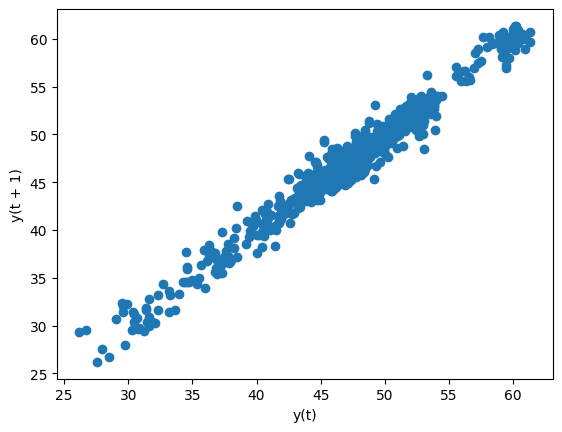

In [54]:
pd.plotting.lag_plot(train_subset_d['oil_price'],lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 30)'>

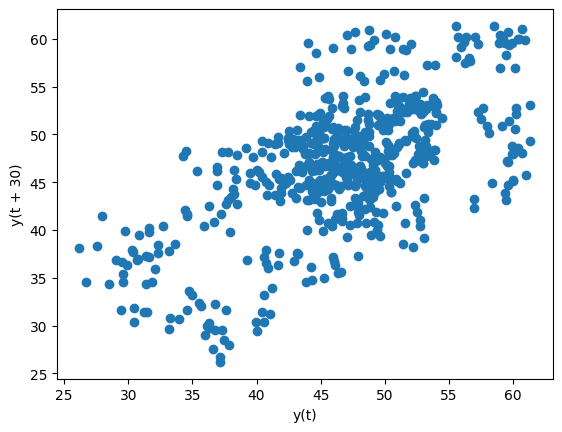

In [55]:
pd.plotting.lag_plot(train_subset_d['oil_price'],lag=30)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

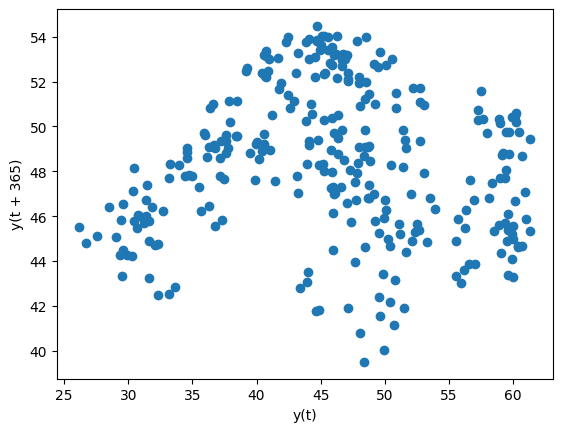

In [56]:
pd.plotting.lag_plot(train_subset_d['oil_price'],lag=365)

## 5.2) Missing Values

In [57]:
# Train Dataset
train_subset_d.isnull().sum()

id             0
store_nbr      0
item_nbr       0
unit_sales     0
Year           0
Month          0
Day            0
class          0
perishable     0
cluster        0
oil_price     25
dtype: int64

Displaying the affected records

In [58]:
train_subset_d.query('oil_price != oil_price')

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-01  3.859434e+07  25.000000  208384.0   37.000000  2015.0    1.0   
2015-01-19  3.962400e+07  26.095238  208384.0   17.285714  2015.0    1.0   
2015-02-16  4.127830e+07  27.600000  208384.0   17.222222  2015.0    2.0   
2015-04-03  4.417240e+07  26.661765  208384.0   19.029412  2015.0    4.0   
2015-05-25  4.743724e+07  27.173913  208384.0   15.369565  2015.0    5.0   
2015-07-03  5.054952e+07  27.163043  208384.0   17.206522  2015.0    7.0   
2015-09-07  5.596668e+07  27.411765  208384.0   12.803922  2015.0    9.0   
2015-11-26  6.317249e+07  29.000000  208384.0    9.333333  2015.0   11.0   
2015-12-25  6.597251e+07  27.177083  208384.0   15.281250  2015.0   12.0   
2016-01-01  6.656135e+07  26.960000  208384.0   21.360000  2016.0    1.0   
2016-01-18  6.802387e+07  27.541667  208384.0   14.520833  2016.0    1.0   
2016-02-15  7.065511e+07  27.653061  208384.0   15.102041  2016.0    2.0   
2016-03-25  7.444512e+07  27.132450  208384.0   15.211921  2016.0    3.0   
2016-05-30  8.068726e+07  27.480000  208384.0   14.160000  2016.0    5.0   
2016-07-04  8.401674e+07  26.959184  208384.0   15.795918  2016.0    7.0   
2016-09-05  9.011011e+07  27.836735  208384.0   14.326531  2016.0    9.0   
2016-11-24  9.787039e+07  28.125000  208384.0    9.041667  2016.0   11.0   
2016-12-26  1.010939e+08  27.037736  208384.0   15.396226  2016.0   12.0   
2017-01-02  1.017459e+08  27.440000  208384.0   22.420000  2017.0    1.0   
2017-01-16  1.032213e+08  27.117647  208384.0   12.137255  2017.0    1.0   
2017-02-20  1.068718e+08  26.530612  208384.0   25.183673  2017.0    2.0   
2017-04-14  1.125060e+08  27.421320  208384.0   14.908629  2017.0    4.0   
2017-05-29  1.172143e+08  27.720000  208384.0   12.920000  2017.0    5.0   
2017-07-03  1.209303e+08  27.115385  208384.0   15.596154  2017.0    7.0   
2017-07-04  1.210397e+08  27.860000  208384.0   12.660000  2017.0    7.0   

                  Day   class  perishable   cluster  oil_price  
date                                                            
2015-01-01   1.000000  2502.0         1.0  1.000000        NaN  
2015-01-19  19.000000  2502.0         1.0  9.357143        NaN  
2015-02-16  16.000000  2502.0         1.0  8.311111        NaN  
2015-04-03   3.985294  2502.0         1.0  8.779412        NaN  
2015-05-25  25.000000  2502.0         1.0  8.347826        NaN  
2015-07-03   3.798913  2502.0         1.0  8.326087        NaN  
2015-09-07   7.000000  2502.0         1.0  8.333333        NaN  
2015-11-26  26.000000  2502.0         1.0  8.222222        NaN  
2015-12-25  26.458333  2502.0         1.0  8.437500        NaN  
2016-01-01   2.520000  2502.0         1.0  8.480000        NaN  
2016-01-18  18.000000  2502.0         1.0  8.166667        NaN  
2016-02-15  15.000000  2502.0         1.0  8.204082        NaN  
2016-03-25  25.993377  2502.0         1.0  8.490066        NaN  
2016-05-30  30.000000  2502.0         1.0  8.440000        NaN  
2016-07-04   4.000000  2502.0         1.0  8.734694        NaN  
2016-09-05   5.000000  2502.0         1.0  8.408163        NaN  
2016-11-24  24.000000  2502.0         1.0  8.000000        NaN  
2016-12-26  26.000000  2502.0         1.0  8.433962        NaN  
2017-01-02   2.000000  2502.0         1.0  8.520000        NaN  
2017-01-16  16.000000  2502.0         1.0  8.411765        NaN  
2017-02-20  20.000000  2502.0         1.0  8.571429        NaN  
2017-04-14  14.751269  2502.0         1.0  8.573604        NaN  
2017-05-29  29.000000  2502.0         1.0  8.600000        NaN  
2017-07-03   3.000000  2502.0         1.0  8.557692        NaN  
2017-07-04   4.000000  2502.0         1.0  8.460000        NaN

### 5.2.1) Oil_price Filling

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 24)'>

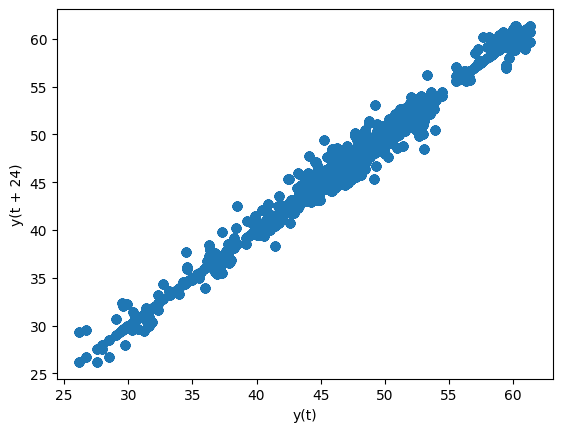

In [59]:
pd.plotting.lag_plot(train_subset['oil_price'],lag=24)


As per the above plot, there is a lineraity with the previous lag for the current lag in oil_price so we can fill the values #
with forward fill(take prev values and fill next value). we can also apply bfill inplace of ffill to fill backwards
(takes future values and take). but backward is not preferrable because furure value will not be available in some business
scenario.

In [60]:
train_subset_d['oil_price'] = train_subset_d['oil_price'].fillna(method='ffill')

In [61]:
train_subset_d.isnull().sum()

id            0
store_nbr     0
item_nbr      0
unit_sales    0
Year          0
Month         0
Day           0
class         0
perishable    0
cluster       0
oil_price     1
dtype: int64

## 5.3) Anomaly Detection

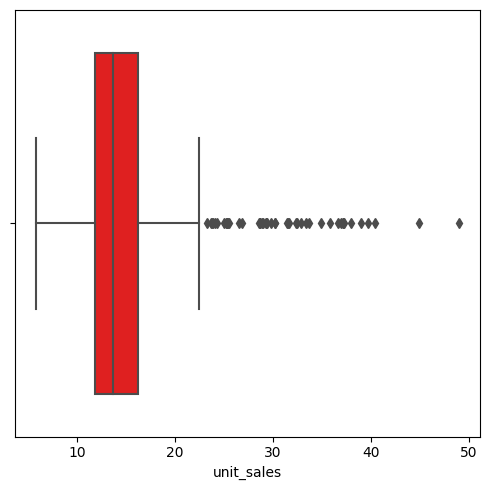

In [62]:
# Outlier Analysis
fig, axs = plt.subplots(1, figsize = (5,5))
plt1 = sns.boxplot(train_subset_d['unit_sales'],color='red')
#plt2 = sns.boxplot(advertising['Newspaper'], ax = axs[1])
#plt3 = sns.boxplot(advertising['Radio'], ax = axs[2])
plt.tight_layout()

In [63]:
unit_sales = train_subset_d["unit_sales"].values
#print(unit_sales.shape)

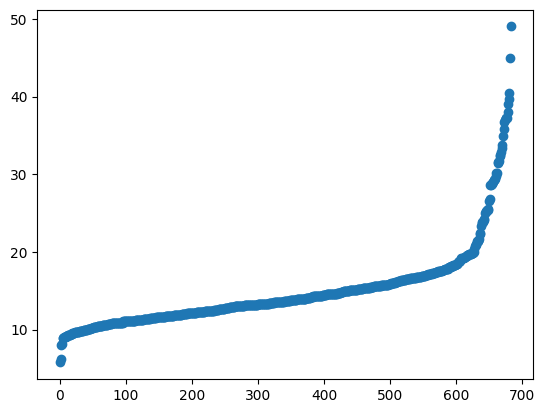

In [64]:
plt.scatter(x = range(unit_sales.shape[0]), y = np.sort(unit_sales))

In [65]:
train_subset_z = train_subset_d.copy()

In [66]:
train_subset_z['z_score'] = (train_subset_z['unit_sales'] - train_subset_z['unit_sales'].mean())/train_subset_z['unit_sales'].std(ddof=0)

<AxesSubplot:xlabel='date'>

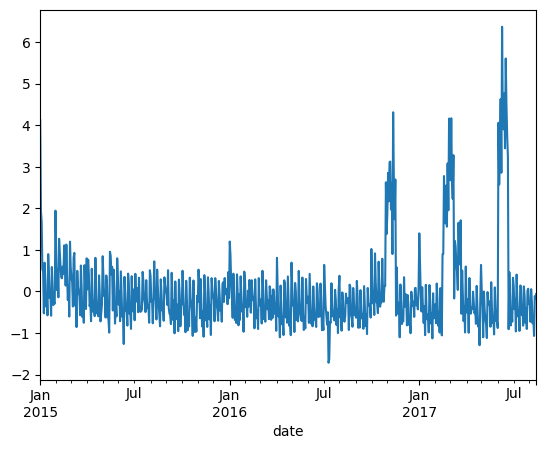

In [67]:
train_subset_z['z_score'].plot()

In [68]:
train_subset_z[train_subset_z['z_score'] > 4]

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-01  3.859434e+07  25.000000  208384.0   37.000000  2015.0    1.0   
2016-11-11  9.669595e+07  27.057592  208384.0   38.000000  2016.0   11.0   
2017-02-28  1.077028e+08  27.297872  208384.0   37.191489  2017.0    2.0   
2017-03-03  1.081367e+08  27.037736  208384.0   37.232704  2017.0    3.0   
2017-06-02  1.177486e+08  27.362500  208384.0   36.656250  2017.0    6.0   
2017-06-07  1.181845e+08  27.666667  208384.0   39.708333  2017.0    6.0   
2017-06-09  1.184937e+08  27.348387  208384.0   49.012903  2017.0    6.0   
2017-06-12  1.187134e+08  27.603774  208384.0   37.188679  2017.0    6.0   
2017-06-14  1.189160e+08  27.607843  208384.0   40.431373  2017.0    6.0   
2017-06-16  1.192308e+08  27.694268  208384.0   44.923567  2017.0    6.0   
2017-06-19  1.194465e+08  26.836735  208384.0   39.040816  2017.0    6.0   

                  Day   class  perishable   cluster  oil_price   z_score  
date                                                                      
2015-01-01   1.000000  2502.0         1.0  1.000000        NaN  4.129508  
2016-11-11  12.036649  2502.0         1.0  8.596859      43.39  4.316651  
2017-02-28  28.000000  2502.0         1.0  8.638298      54.00  4.165344  
2017-03-03   4.000000  2502.0         1.0  8.433962      53.33  4.173057  
2017-06-02   3.000000  2502.0         1.0  8.487500      47.68  4.065177  
2017-06-07   7.000000  2502.0         1.0  8.291667      45.80  4.636354  
2017-06-09  10.000000  2502.0         1.0  8.593548      45.82  6.377639  
2017-06-12  12.000000  2502.0         1.0  8.509434      46.10  4.164818  
2017-06-14  14.000000  2502.0         1.0  8.352941      44.79  4.771665  
2017-06-16  17.012739  2502.0         1.0  8.356688      44.73  5.612348  
2017-06-19  19.000000  2502.0         1.0  8.816327      44.24  4.511432

In [69]:
#exclude the rows with z score more than 4
from scipy.stats import zscore
train_subset_z = train_subset_z[(np.abs(zscore(train_subset_z['z_score'])) < 2)]

In [70]:
unit_sales_z = train_subset_z['z_score'].values

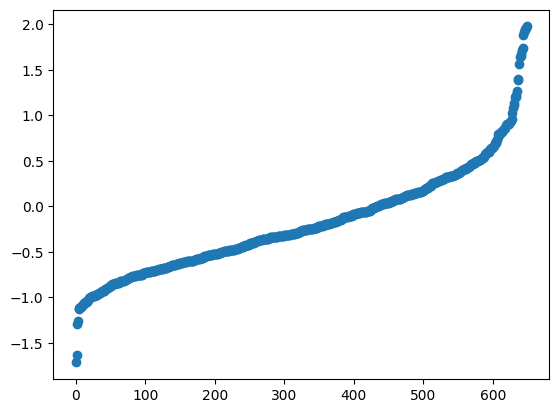

In [71]:
plt.scatter(x = range(unit_sales_z.shape[0]), y = np.sort(unit_sales_z))

In [306]:
train_subset_z.shape

(650, 12)

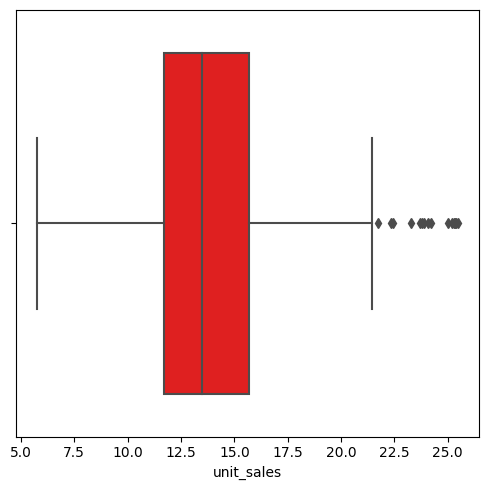

In [72]:
# Outlier Analysis
fig, axs = plt.subplots(1, figsize = (5,5))
plt1 = sns.boxplot(train_subset_z['unit_sales'],color='red')
plt.tight_layout()

### Standardisation

In [73]:
train_subset_s = train_subset_z.copy()

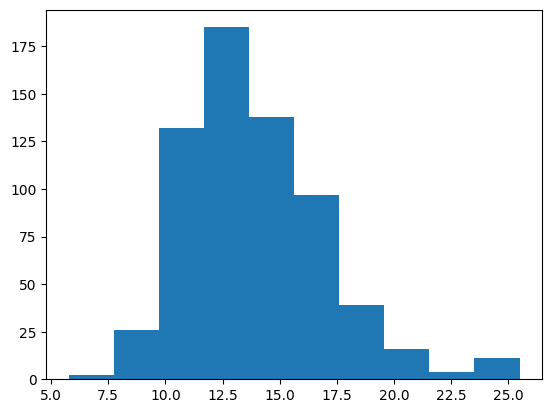

In [74]:
# histogram plot
plt.hist(train_subset_s['unit_sales'])
plt.show()

<AxesSubplot:ylabel='Density'>

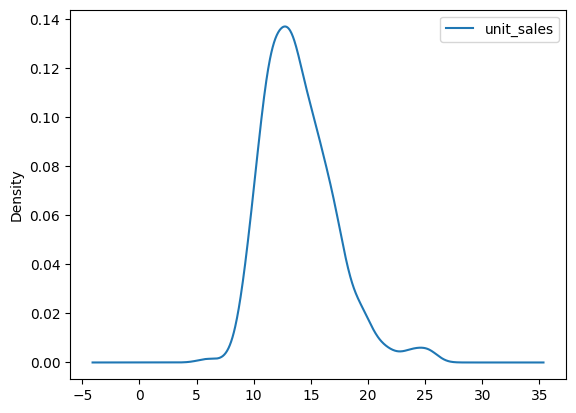

In [75]:
train_subset_s[['unit_sales']].plot(kind='density')

In [76]:
train_subset_ss = train_subset_s.copy()

In [77]:
from sklearn.preprocessing import StandardScaler
scale= StandardScaler()
scaled_data = scale.fit_transform(train_subset_ss) 
print(scaled_data)

[[-1.51371483 -1.2590777   0.         ...  1.7856534   0.87487397
   3.66851288]
 [-1.50874853  2.27609432  0.         ... -0.70492353  0.48489209
   3.21227713]
 [-1.5064842   0.18331242  0.         ... -0.02875468  0.18254658
   1.24752267]
 ...
 [ 1.90644586  2.03714169  0.         ... -0.70877896  0.3037769
   0.12075583]
 [ 1.91478561  1.51688713  0.         ...  0.48844984  0.12558293
   0.01352576]
 [ 1.91883872  1.26483305  0.         ...  1.19580309  0.12266172
   0.21229742]]


In [78]:
train_subset_ss.drop(columns=['id','z_score'],inplace=True)


<AxesSubplot:ylabel='Density'>

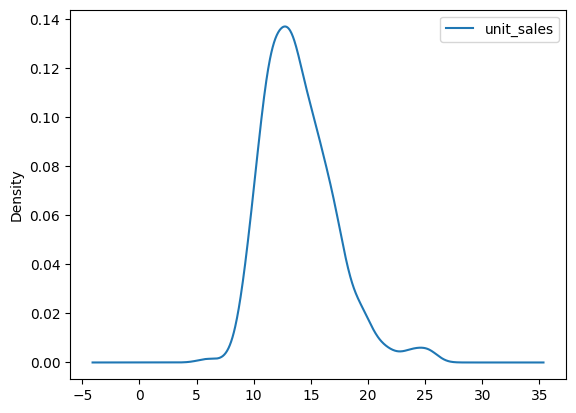

In [79]:
train_subset_ss[['unit_sales']].plot(kind='density')

## 5.5) Correlation

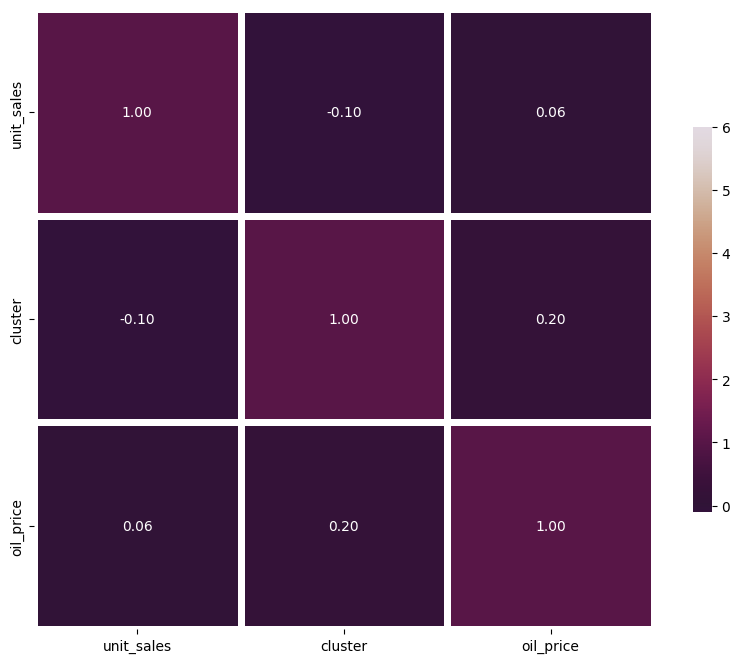

In [80]:
train_corr = train_subset_d[['unit_sales','cluster','oil_price']].corr(method='pearson')
train_corr
g = sns.heatmap(train_corr,vmax=6,center=0,
               square = True,linewidths=5,cbar_kws = {'shrink':.5},annot=True,fmt='.2f',cmap='twilight')
g.figure.set_size_inches(10,10)

In [81]:
train_corr = train_subset_ss[['unit_sales','cluster','oil_price']].corr(method='pearson')
train_corr

unit_sales   cluster  oil_price
unit_sales    1.000000  0.105611   0.081837
cluster       0.105611  1.000000   0.207345
oil_price     0.081837  0.207345   1.000000

# 6) TimeSeries Components - train_subset_d

## 6.1) Decomposition

In [82]:
df_decomp = train_subset_s.copy()

In [83]:
df_decomp

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-02  3.868373e+07  26.661417  208384.0   25.283465  2015.0    1.0   
2015-01-05  3.880926e+07  28.600000  208384.0   23.875000  2015.0    1.0   
2015-01-06  3.886649e+07  27.452381  208384.0   17.809524  2015.0    1.0   
2015-01-07  3.892401e+07  27.139535  208384.0   17.488372  2015.0    1.0   
2015-01-08  3.898065e+07  26.170732  208384.0   12.121951  2015.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.613636  2017.0    8.0   

                  Day   class  perishable   cluster  oil_price   z_score  
date                                                                      
2015-01-02   2.968504  2502.0         1.0  8.881890      52.72  1.936839  
2015-01-05   5.000000  2502.0         1.0  8.325000      50.05  1.673255  
2015-01-06   6.000000  2502.0         1.0  8.476190      47.98  0.538143  
2015-01-07   7.000000  2502.0         1.0  8.488372      48.69  0.478042  
2015-01-08   8.000000  2502.0         1.0  9.170732      48.80 -0.526247  
...               ...     ...         ...       ...        ...       ...  
2017-08-09   9.000000  2502.0         1.0  8.326087      49.59 -0.630436  
2017-08-10  10.000000  2502.0         1.0  8.274510      48.54 -1.070134  
2017-08-11  11.993103  2502.0         1.0  8.324138      48.81 -0.112832  
2017-08-14  14.000000  2502.0         1.0  8.591837      47.59 -0.174783  
2017-08-15  15.000000  2502.0         1.0  8.750000      47.57 -0.059945  

[650 rows x 12 columns]

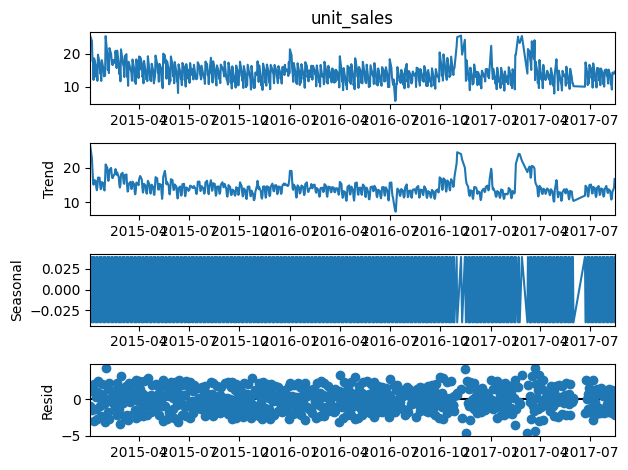

In [84]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df_decomp['unit_sales'],
                                model='additive',period=2,extrapolate_trend='freq')

resplot = res.plot()

<AxesSubplot:xlabel='date'>

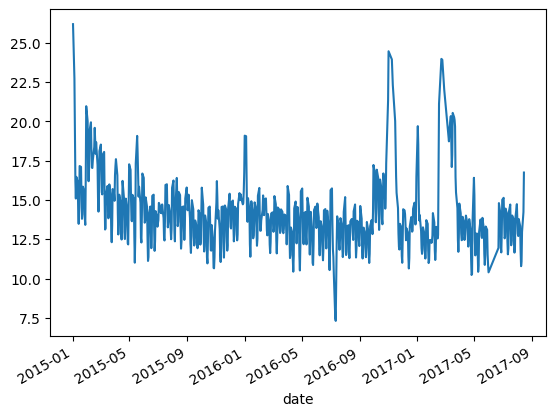

In [85]:
res.trend.plot()

<AxesSubplot:xlabel='date'>

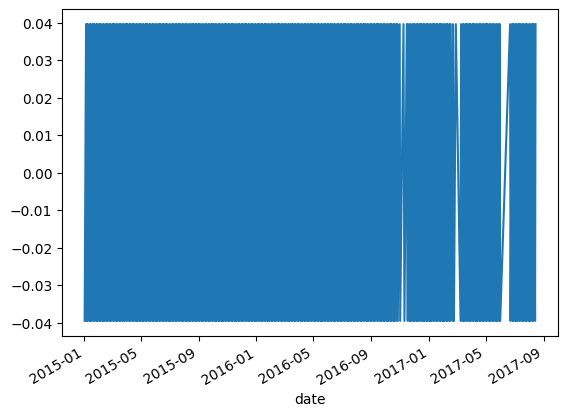

In [86]:
res.seasonal.plot()

<AxesSubplot:xlabel='date'>

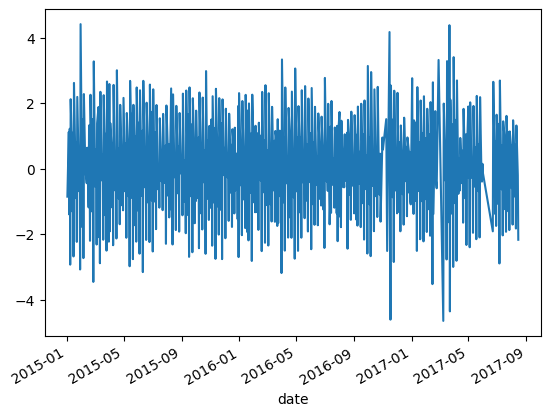

In [87]:
res.resid.plot()

In [88]:
res.observed #ACTUAL UNIT_SALES Value

date
2015-01-02    25.283465
2015-01-05    23.875000
2015-01-06    17.809524
2015-01-07    17.488372
2015-01-08    12.121951
                ...    
2017-08-09    11.565217
2017-08-10     9.215686
2017-08-11    14.331034
2017-08-14    14.000000
2017-08-15    14.613636
Name: unit_sales, Length: 650, dtype: float64

In [89]:
print(res.trend)

date
2015-01-02    26.175889
2015-01-05    22.710747
2015-01-06    19.245605
2015-01-07    16.227055
2015-01-08    15.091983
                ...    
2017-08-09    10.793977
2017-08-10    11.081906
2017-08-11    12.969439
2017-08-14    14.236168
2017-08-15    16.744504
Name: trend, Length: 650, dtype: float64


In [90]:
print(res.seasonal)

date
2015-01-02   -0.039568
2015-01-05    0.039568
2015-01-06   -0.039568
2015-01-07    0.039568
2015-01-08   -0.039568
                ...   
2017-08-09    0.039568
2017-08-10   -0.039568
2017-08-11    0.039568
2017-08-14   -0.039568
2017-08-15    0.039568
Name: seasonal, Length: 650, dtype: float64


In [91]:
res.trend[1] + res.seasonal[1] + res.resid[1]

23.875

### 6.1.a) Detrend the data

<AxesSubplot:xlabel='date'>

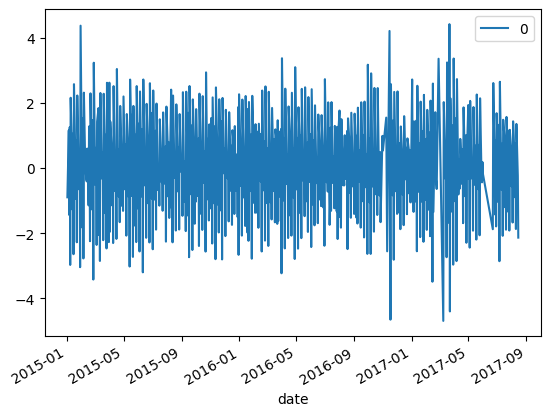

In [92]:
pd.DataFrame(res.observed-res.trend).plot()

In [93]:
detrend = pd.DataFrame(res.observed/res.trend)

In [94]:
#detrend.rename(columns = {0:'detrend_sales'},inplace=True)
detrend

0
date                
2015-01-02  0.965907
2015-01-05  1.051264
2015-01-06  0.925381
2015-01-07  1.077729
2015-01-08  0.803205
...              ...
2017-08-09  1.071451
2017-08-10  0.831598
2017-08-11  1.104985
2017-08-14  0.983411
2017-08-15  0.872742

[650 rows x 1 columns]

<AxesSubplot:xlabel='date'>

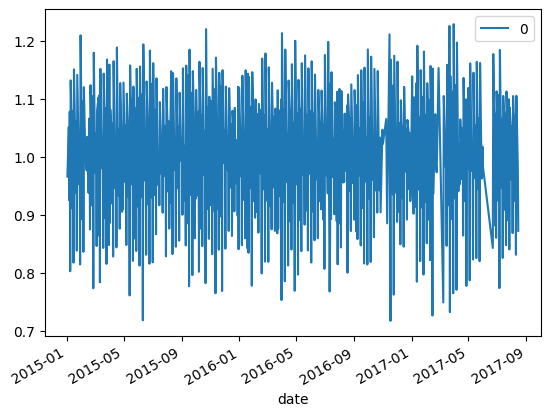

In [95]:
detrend.plot()

In [96]:
train_subset_sbkp = train_subset_s.copy()

In [97]:
train_subset_s = pd.concat([train_subset_s,detrend[0]],axis=1)

In [98]:
train_subset_s = train_subset_s.rename(columns={0:'unit_sales_detrend'})

<AxesSubplot:xlabel='date'>

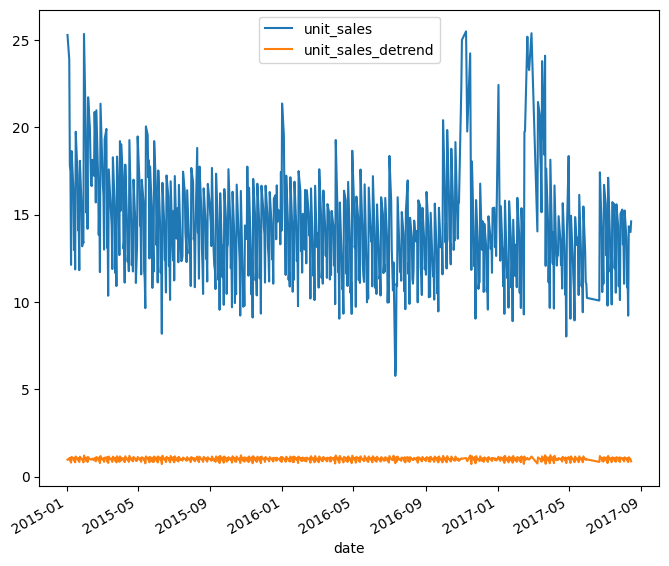

In [99]:
train_subset_s[['unit_sales','unit_sales_detrend']].plot(figsize=(8,7))

<AxesSubplot:xlabel='date'>

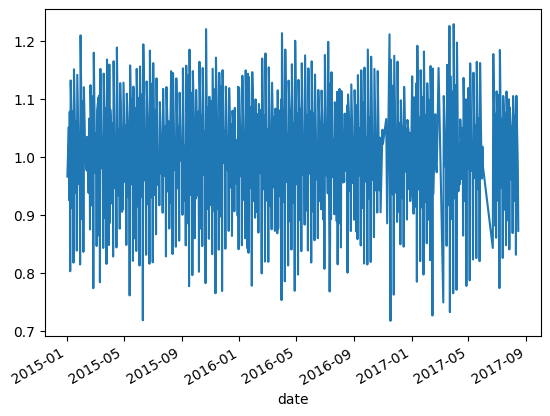

In [100]:
train_subset_s['unit_sales_detrend'].plot()

In [101]:
#train_subset_s['unit_sales_detrend'] = train_subset_s['unit_sales_detrend'].fillna(method='bfill')

In [102]:
train_subset_s.isnull().sum()

id                    0
store_nbr             0
item_nbr              0
unit_sales            0
Year                  0
Month                 0
Day                   0
class                 0
perishable            0
cluster               0
oil_price             0
z_score               0
unit_sales_detrend    0
dtype: int64

## 6.2) Handling Stationarity

### 6.2.1) ADF

In [103]:
train_subset_s.isnull().sum()

id                    0
store_nbr             0
item_nbr              0
unit_sales            0
Year                  0
Month                 0
Day                   0
class                 0
perishable            0
cluster               0
oil_price             0
z_score               0
unit_sales_detrend    0
dtype: int64

In [104]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_subset_s['unit_sales_detrend'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -7.626554
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Reject Ho - Time Series is Stationary


### 6.2.2) KPSS Test

In [105]:
from statsmodels.tsa.stattools import kpss
tstest = kpss(train_subset_s['unit_sales_detrend'],'ct')

C:\Users\u2195687\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [106]:
tstest

(0.07263398762086405,
 0.1,
 29,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

## 6.3) Handling Residuals by smoothening

In [107]:
train_subset_s

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-02  3.868373e+07  26.661417  208384.0   25.283465  2015.0    1.0   
2015-01-05  3.880926e+07  28.600000  208384.0   23.875000  2015.0    1.0   
2015-01-06  3.886649e+07  27.452381  208384.0   17.809524  2015.0    1.0   
2015-01-07  3.892401e+07  27.139535  208384.0   17.488372  2015.0    1.0   
2015-01-08  3.898065e+07  26.170732  208384.0   12.121951  2015.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.613636  2017.0    8.0   

                  Day   class  perishable   cluster  oil_price   z_score  \
date                                                                       
2015-01-02   2.968504  2502.0         1.0  8.881890      52.72  1.936839   
2015-01-05   5.000000  2502.0         1.0  8.325000      50.05  1.673255   
2015-01-06   6.000000  2502.0         1.0  8.476190      47.98  0.538143   
2015-01-07   7.000000  2502.0         1.0  8.488372      48.69  0.478042   
2015-01-08   8.000000  2502.0         1.0  9.170732      48.80 -0.526247   
...               ...     ...         ...       ...        ...       ...   
2017-08-09   9.000000  2502.0         1.0  8.326087      49.59 -0.630436   
2017-08-10  10.000000  2502.0         1.0  8.274510      48.54 -1.070134   
2017-08-11  11.993103  2502.0         1.0  8.324138      48.81 -0.112832   
2017-08-14  14.000000  2502.0         1.0  8.591837      47.59 -0.174783   
2017-08-15  15.000000  2502.0         1.0  8.750000      47.57 -0.059945   

            unit_sales_detrend  
date                            
2015-01-02            0.965907  
2015-01-05            1.051264  
2015-01-06            0.925381  
2015-01-07            1.077729  
2015-01-08            0.803205  
...                        ...  
2017-08-09            1.071451  
2017-08-10            0.831598  
2017-08-11            1.104985  
2017-08-14            0.983411  
2017-08-15            0.872742  

[650 rows x 13 columns]

In [108]:
train_split = train_subset_s.loc['2015-01-01':'2017-08-08']

In [109]:
test_split = train_subset_s.loc['2017-08-09':'2017-08-15']

In [110]:
train_split

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-02  3.868373e+07  26.661417  208384.0   25.283465  2015.0    1.0   
2015-01-05  3.880926e+07  28.600000  208384.0   23.875000  2015.0    1.0   
2015-01-06  3.886649e+07  27.452381  208384.0   17.809524  2015.0    1.0   
2015-01-07  3.892401e+07  27.139535  208384.0   17.488372  2015.0    1.0   
2015-01-08  3.898065e+07  26.170732  208384.0   12.121951  2015.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-02  1.240871e+08  27.560000  208384.0   13.520000  2017.0    8.0   
2017-08-03  1.241925e+08  28.021277  208384.0   11.042553  2017.0    8.0   
2017-08-04  1.244067e+08  28.211921  208384.0   15.231788  2017.0    8.0   
2017-08-07  1.246219e+08  28.204082  208384.0   13.653061  2017.0    8.0   
2017-08-08  1.247256e+08  28.893617  208384.0   10.829787  2017.0    8.0   

                 Day   class  perishable   cluster  oil_price   z_score  \
date                                                                      
2015-01-02  2.968504  2502.0         1.0  8.881890      52.72  1.936839   
2015-01-05  5.000000  2502.0         1.0  8.325000      50.05  1.673255   
2015-01-06  6.000000  2502.0         1.0  8.476190      47.98  0.538143   
2015-01-07  7.000000  2502.0         1.0  8.488372      48.69  0.478042   
2015-01-08  8.000000  2502.0         1.0  9.170732      48.80 -0.526247   
...              ...     ...         ...       ...        ...       ...   
2017-08-02  2.000000  2502.0         1.0  8.720000      49.60 -0.264612   
2017-08-03  3.000000  2502.0         1.0  8.319149      49.03 -0.728249   
2017-08-04  5.019868  2502.0         1.0  8.476821      49.57  0.055738   
2017-08-07  7.000000  2502.0         1.0  8.489796      49.37 -0.239710   
2017-08-08  8.000000  2502.0         1.0  8.319149      49.07 -0.768066   

            unit_sales_detrend  
date                            
2015-01-02            0.965907  
2015-01-05            1.051264  
2015-01-06            0.925381  
2015-01-07            1.077729  
2015-01-08            0.803205  
...                        ...  
2017-08-02            1.052459  
2017-08-03            0.868861  
2017-08-04            1.104569  
2017-08-07            1.023320  
2017-08-08            0.924086  

[645 rows x 13 columns]

In [111]:
test_split

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.613636  2017.0    8.0   

                  Day   class  perishable   cluster  oil_price   z_score  \
date                                                                       
2017-08-09   9.000000  2502.0         1.0  8.326087      49.59 -0.630436   
2017-08-10  10.000000  2502.0         1.0  8.274510      48.54 -1.070134   
2017-08-11  11.993103  2502.0         1.0  8.324138      48.81 -0.112832   
2017-08-14  14.000000  2502.0         1.0  8.591837      47.59 -0.174783   
2017-08-15  15.000000  2502.0         1.0  8.750000      47.57 -0.059945   

            unit_sales_detrend  
date                            
2017-08-09            1.071451  
2017-08-10            0.831598  
2017-08-11            1.104985  
2017-08-14            0.983411  
2017-08-15            0.872742

### 6.1.1) Simple Moving Average

In [112]:
df_sma = train_subset_s.copy()

In [113]:
train_subset_s.drop

<bound method DataFrame.drop of                       id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-02  3.868373e+07  26.661417  208384.0   25.283465  2015.0    1.0   
2015-01-05  3.880926e+07  28.600000  208384.0   23.875000  2015.0    1.0   
2015-01-06  3.886649e+07  27.452381  208384.0   17.809524  2015.0    1.0   
2015-01-07  3.892401e+07  27.139535  208384.0   17.488372  2015.0    1.0   
2015-01-08  3.898065e+07  26.170732  208384.0   12.121951  2015.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.61363

In [114]:
#df_sma = df_sma[['unit_sales_detrend']]

In [115]:
df_sma['ma_rolling_3'] = df_sma['unit_sales_detrend'].rolling(window=3).mean().shift(1)

<AxesSubplot:xlabel='date'>

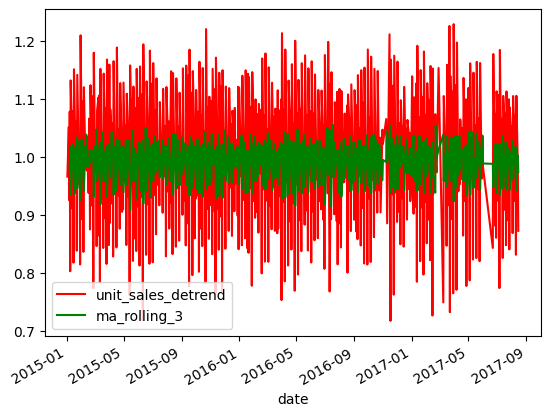

In [116]:
df_sma[['unit_sales_detrend','ma_rolling_3']].plot(color=['red','green'])

### 6.1.2 Weighted Moving average

In [117]:
def wma(weights):
    def calc(x):
        return (weights*x).mean()
    return calc

In [118]:
df_sma['wma_rolling_3'] = df_sma['unit_sales_detrend'].rolling(window=3).apply(wma(np.array([0.5,1,1.5]))).shift(1)

<AxesSubplot:xlabel='date'>

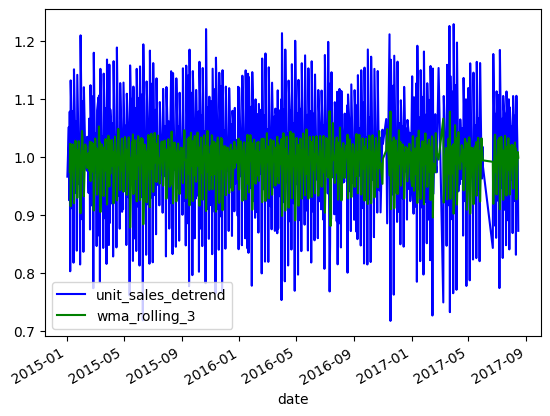

In [119]:
df_sma[['unit_sales_detrend','wma_rolling_3']].plot(color=['blue','green'])

### 6.1.3) Exponential Weighted  Moving Average

In [120]:
df_sma['ewm_window_3'] = df_sma['unit_sales_detrend'].ewm(span=3,adjust=False,min_periods=0).mean().shift(1)

<AxesSubplot:xlabel='date'>

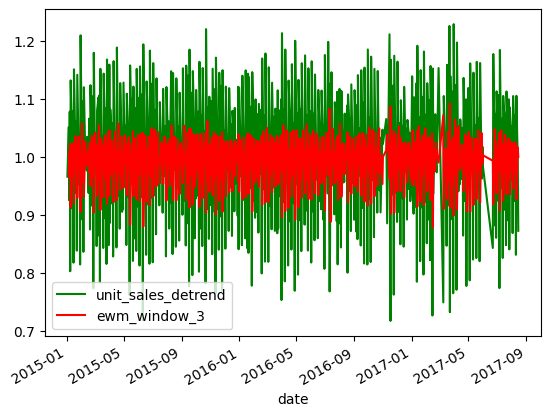

In [121]:
df_sma[['unit_sales_detrend','ewm_window_3']].plot(color=['green','red'])

In [122]:
def rmse(x,y):
    return ((df_sma[x]-df_sma[y])**2).mean()**0.5
print('Moving Average')
print(rmse('unit_sales_detrend','ma_rolling_3'))
print('Weighted Moving Average')
print(rmse('unit_sales_detrend','wma_rolling_3'))
print('Exponential Weighted Moving Average')
print(rmse('unit_sales_detrend','ewm_window_3'))

Moving Average
0.12717802366238062
Weighted Moving Average
0.1422072088070689
Exponential Weighted Moving Average
0.14627379829275172


Moving average gives the best results

<AxesSubplot:xlabel='date'>

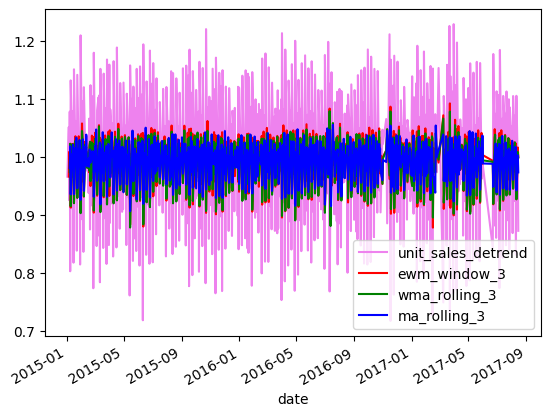

In [123]:
df_sma[['unit_sales_detrend','ewm_window_3','wma_rolling_3','ma_rolling_3']].plot(color=['violet','red','green','blue'])

# PROPHET

In [183]:
#!pip install pystan fbprophet

In [184]:
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

In [185]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [186]:
#train_subset_d

In [187]:
df_pro = train_subset_d.copy()

In [188]:
df_pro

id  store_nbr  item_nbr  unit_sales    Year  Month  \
date                                                                       
2015-01-01  3.859434e+07  25.000000  208384.0   37.000000  2015.0    1.0   
2015-01-02  3.868373e+07  26.661417  208384.0   25.283465  2015.0    1.0   
2015-01-05  3.880926e+07  28.600000  208384.0   23.875000  2015.0    1.0   
2015-01-06  3.886649e+07  27.452381  208384.0   17.809524  2015.0    1.0   
2015-01-07  3.892401e+07  27.139535  208384.0   17.488372  2015.0    1.0   
...                  ...        ...       ...         ...     ...    ...   
2017-08-09  1.248265e+08  28.847826  208384.0   11.565217  2017.0    8.0   
2017-08-10  1.249255e+08  28.411765  208384.0    9.215686  2017.0    8.0   
2017-08-11  1.251311e+08  28.468966  208384.0   14.331034  2017.0    8.0   
2017-08-14  1.253419e+08  28.183673  208384.0   14.000000  2017.0    8.0   
2017-08-15  1.254443e+08  28.045455  208384.0   14.613636  2017.0    8.0   

                  Day   class  perishable   cluster  oil_price  
date                                                            
2015-01-01   1.000000  2502.0         1.0  1.000000        NaN  
2015-01-02   2.968504  2502.0         1.0  8.881890      52.72  
2015-01-05   5.000000  2502.0         1.0  8.325000      50.05  
2015-01-06   6.000000  2502.0         1.0  8.476190      47.98  
2015-01-07   7.000000  2502.0         1.0  8.488372      48.69  
...               ...     ...         ...       ...        ...  
2017-08-09   9.000000  2502.0         1.0  8.326087      49.59  
2017-08-10  10.000000  2502.0         1.0  8.274510      48.54  
2017-08-11  11.993103  2502.0         1.0  8.324138      48.81  
2017-08-14  14.000000  2502.0         1.0  8.591837      47.59  
2017-08-15  15.000000  2502.0         1.0  8.750000      47.57  

[684 rows x 11 columns]

In [189]:
df_pro_a =df_pro.reset_index()[['date','unit_sales']].rename({'date':'ds','unit_sales':'y'}, axis='columns')

In [190]:
df_pro_b = df_pro_a.copy()

In [191]:
train_pro=df_pro_a[(df_pro_a['ds'] >= '2015-01-01') & (df_pro_a['ds'] <= '2017-08-09')]
test_pro=df_pro_a[(df_pro_a['ds'] > '2017-08-09')]

## Prophet1

In [192]:
m = Prophet(interval_width=0.95)
m.fit(train_pro)

10:54:19 - cmdstanpy - INFO - Chain [1] start processing
10:54:19 - cmdstanpy - INFO - Chain [1] done processing


In [193]:
#m.params

In [194]:
future = m.make_future_dataframe(periods=369,freq='B') # 4 is test data shape
forecast1 = m.predict(future)
forecast1.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-01-01  19.878751    7.063474   22.823650    19.878751    19.878751   
1 2015-01-02  19.868327   12.787009   29.399220    19.868327    19.868327   
2 2015-01-05  19.837053   10.455197   25.918745    19.837053    19.837053   
3 2015-01-06  19.826628    8.378647   23.536835    19.826628    19.826628   
4 2015-01-07  19.816203    9.150429   24.207645    19.816203    19.816203   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -5.052877             -5.052877             -5.052877 -6.320405   
1        1.124926              1.124926              1.124926 -0.034667   
2       -1.712586             -1.712586             -1.712586 -2.500785   
3       -3.979772             -3.979772             -3.979772 -4.634728   
4       -3.078566             -3.078566             -3.078566 -3.598074   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -6.320405     -6.320405  1.267528      1.267528      1.267528   
1     -0.034667     -0.034667  1.159593      1.159593      1.159593   
2     -2.500785     -2.500785  0.788199      0.788199      0.788199   
3     -4.634728     -4.634728  0.654957      0.654957      0.654957   
4     -3.598074     -3.598074  0.519508      0.519508      0.519508   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  14.825874  
1                         0.0  20.993253  
2                         0.0  18.124467  
3                         0.0  15.846856  
4                         0.0  16.737637

In [195]:
prophet1 = forecast1['yhat']

<AxesSubplot:xlabel='ds'>

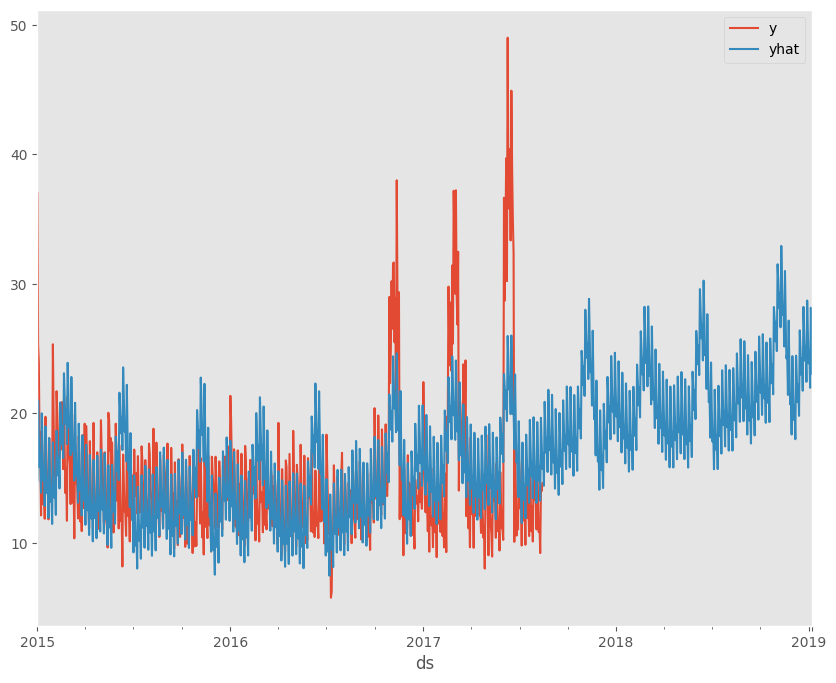

In [196]:
pd.concat([df_pro_a.set_index('ds')['y'],forecast1.set_index('ds')['yhat']],axis=1).plot()

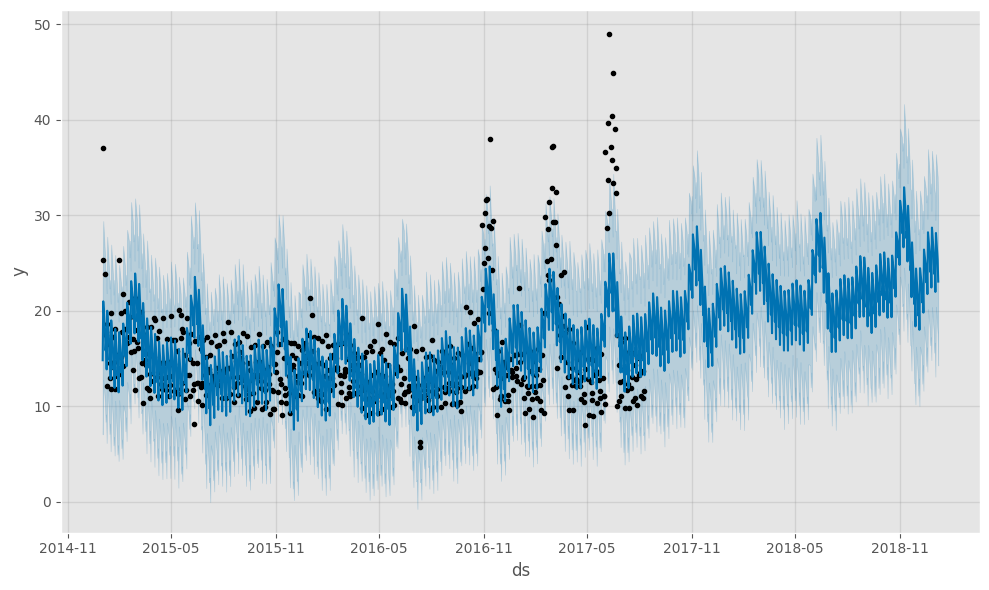

In [197]:
fig1 = m.plot(forecast1)

In [198]:
#fig2 = m.plot_components(forecast)

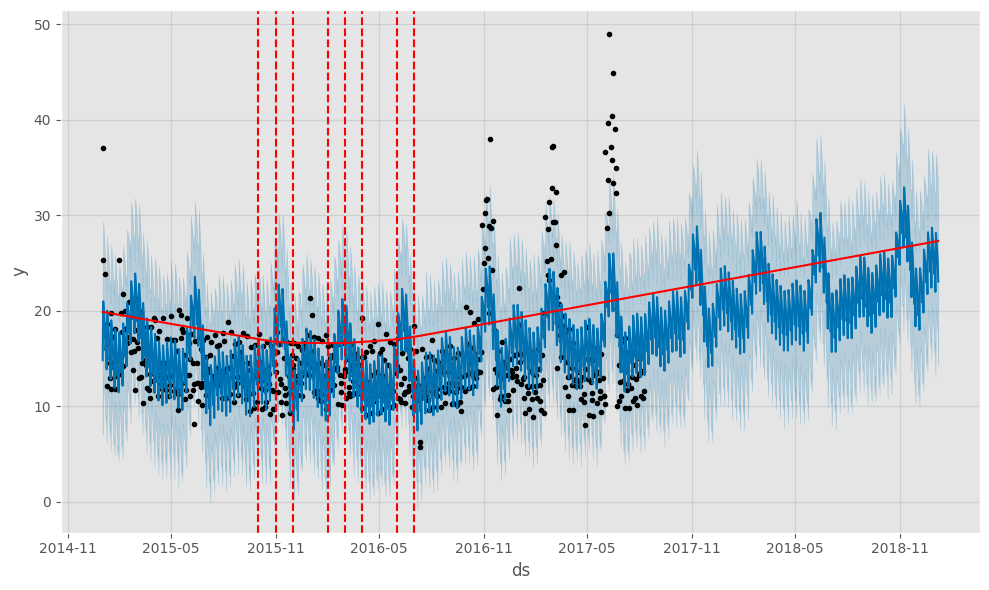

In [200]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast1)
a = add_changepoints_to_plot(fig.gca(), m, forecast1)

In [201]:
se = np.square(forecast1.loc[:, 'yhat'] - df_pro_a['y'])
mse1 = np.mean(se)
rmse1 = np.sqrt(mse1)
print(mse1)
print(rmse1)

16.13996392332231
4.017457395333809


In [411]:
from sklearn.metrics import r2_score

In [415]:
df_pro_a

ds          y
0   2015-01-01  37.000000
1   2015-01-02  25.283465
2   2015-01-05  23.875000
3   2015-01-06  17.809524
4   2015-01-07  17.488372
..         ...        ...
679 2017-08-09  11.565217
680 2017-08-10   9.215686
681 2017-08-11  14.331034
682 2017-08-14  14.000000
683 2017-08-15  14.613636

[684 rows x 2 columns]

In [419]:
print('mse value is',((forecast1.loc[:, 'yhat'] - df_pro_a['y'])**2).mean()**0.5)
print('rmse value is',((forecast1.loc[:, 'yhat'] - df_pro_a['y']) ** 2).mean())
print('mape value is',np.mean(np.abs(((forecast1.loc[:, 'yhat'] - df_pro_a['y'])) / forecast1.loc[:, 'yhat'])) * 100)
print('r_squared is',r2_score(forecast1.loc[:683, 'yhat'], df_pro_a['y']))

mse value is 4.017457395333809
rmse value is 16.13996392332231
mape value is 17.356442427763756
r_squared is -0.33206816920676907


## Prophet 2 - seasonality included

10:54:51 - cmdstanpy - INFO - Chain [1] start processing
10:54:51 - cmdstanpy - INFO - Chain [1] done processing


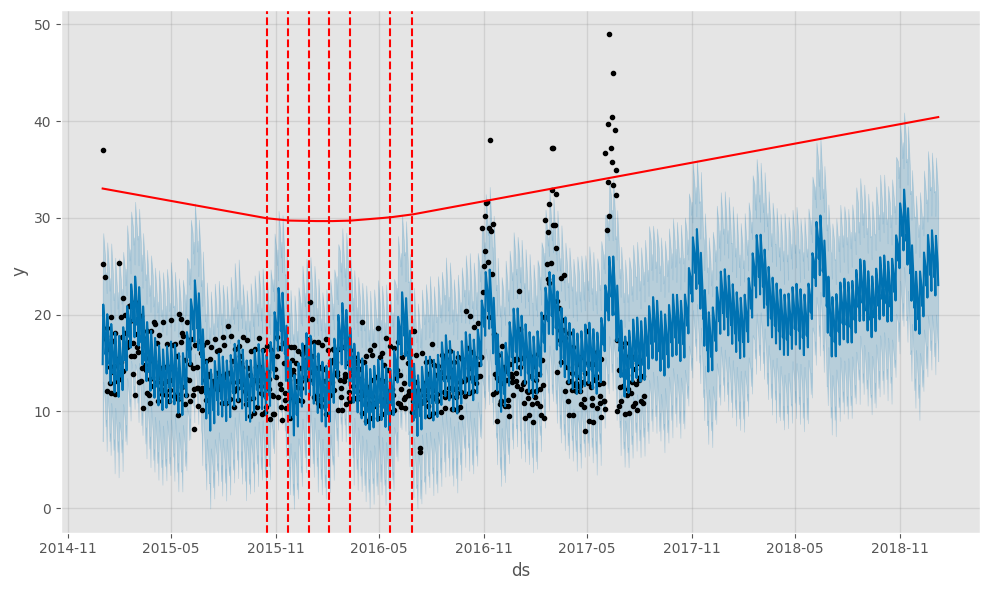

In [202]:
pro_change= Prophet(interval_width=0.95,changepoint_range = 0.95, daily_seasonality=True)
forecast2 = pro_change.fit(train_pro).predict(future)
fig4 = pro_change.plot(forecast2);
b = add_changepoints_to_plot(fig4.gca(), pro_change, forecast2)

In [203]:
ae = np.square(forecast2.loc[:, 'yhat'] - df_pro_b['y'])
mse2 = np.mean(ae)
rmse2 = np.sqrt(mse2)
print(mse2)
print(rmse2)

16.14996618503385
4.018702052284276


In [420]:
print('mse value is',((forecast2.loc[:, 'yhat'] - df_pro_b['y'])**2).mean()**0.5)
print('rmse value is',((forecast2.loc[:, 'yhat'] - df_pro_b['y']) ** 2).mean())
print('mape value is',np.mean(np.abs(((forecast2.loc[:, 'yhat'] - df_pro_b['y'])) / forecast2.loc[:, 'yhat'])) * 100)
print('r_squared is',r2_score(forecast2.loc[:683, 'yhat'], df_pro_b['y']))

mse value is 4.018702052284276
rmse value is 16.14996618503385
mape value is 17.386673768902796
r_squared is -0.32979559714441953


## Prophet 3 - seasonality included and holiday included

In [204]:
holi = df_holiday.copy()

In [205]:
holi = holi[['date','type']]

In [206]:
holi = holi.reset_index()[['date','type']].rename({'date':'ds','type':'holiday'}, axis='columns')

In [207]:
holi

ds     holiday
0   2012-03-02     Holiday
1   2012-04-01     Holiday
2   2012-04-12     Holiday
3   2012-04-14     Holiday
4   2012-04-21     Holiday
..         ...         ...
345 2017-12-22  Additional
346 2017-12-23  Additional
347 2017-12-24  Additional
348 2017-12-25     Holiday
349 2017-12-26  Additional

[350 rows x 2 columns]

10:55:06 - cmdstanpy - INFO - Chain [1] start processing
10:55:06 - cmdstanpy - INFO - Chain [1] done processing


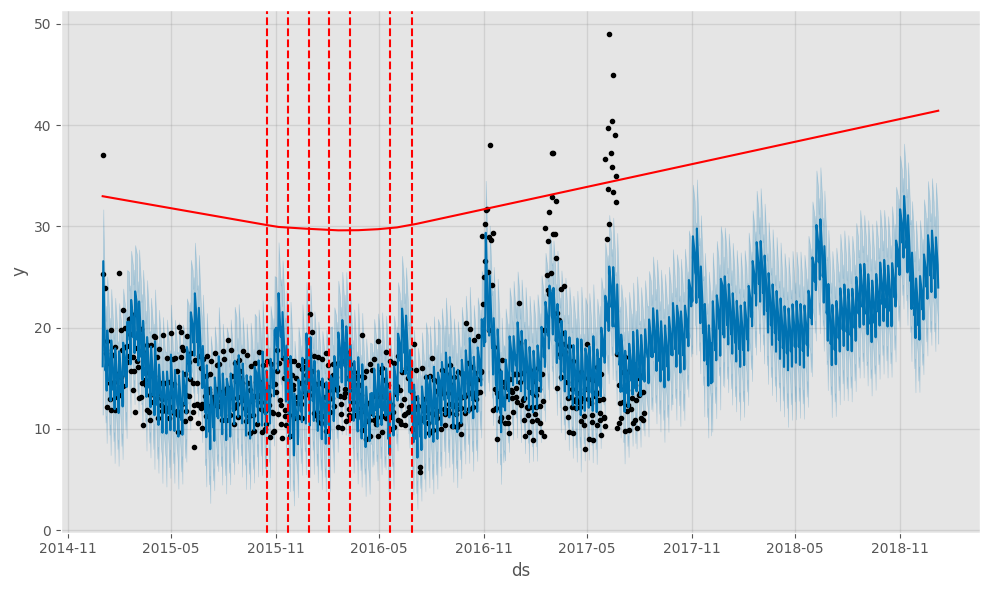

In [208]:
hol_change= Prophet(changepoint_range = 0.90, daily_seasonality=True,holidays=holi)
forecast3 = hol_change.fit(train_pro).predict(future)
fig5 = pro_change.plot(forecast3);
c = add_changepoints_to_plot(fig5.gca(), pro_change, forecast3)

In [209]:
be = np.square(forecast3.loc[:, 'yhat'] - df_pro_b['y'])
mse3 = np.mean(be)
rmse3 = np.sqrt(mse3)
print(mse3)
print(rmse3)

15.753969731676962
3.9691270742667037


In [421]:
print('mse value is',((forecast3.loc[:, 'yhat'] - df_pro_b['y'])**2).mean()**0.5)
print('rmse value is',((forecast3.loc[:, 'yhat'] - df_pro_b['y']) ** 2).mean())
print('mape value is',np.mean(np.abs(((forecast3.loc[:, 'yhat'] - df_pro_b['y'])) / forecast2.loc[:, 'yhat'])) * 100)
print('r_squared is',r2_score(forecast3.loc[:683, 'yhat'], df_pro_b['y']))

mse value is 3.9691270742667037
rmse value is 15.753969731676962
mape value is 17.27983932305518
r_squared is -0.26077736638735893


# ARIMA & SARIMA

Auto correlation (ACF and PACF plots)

In [427]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [468]:
df_arma = train_subset.resample('B').mean()

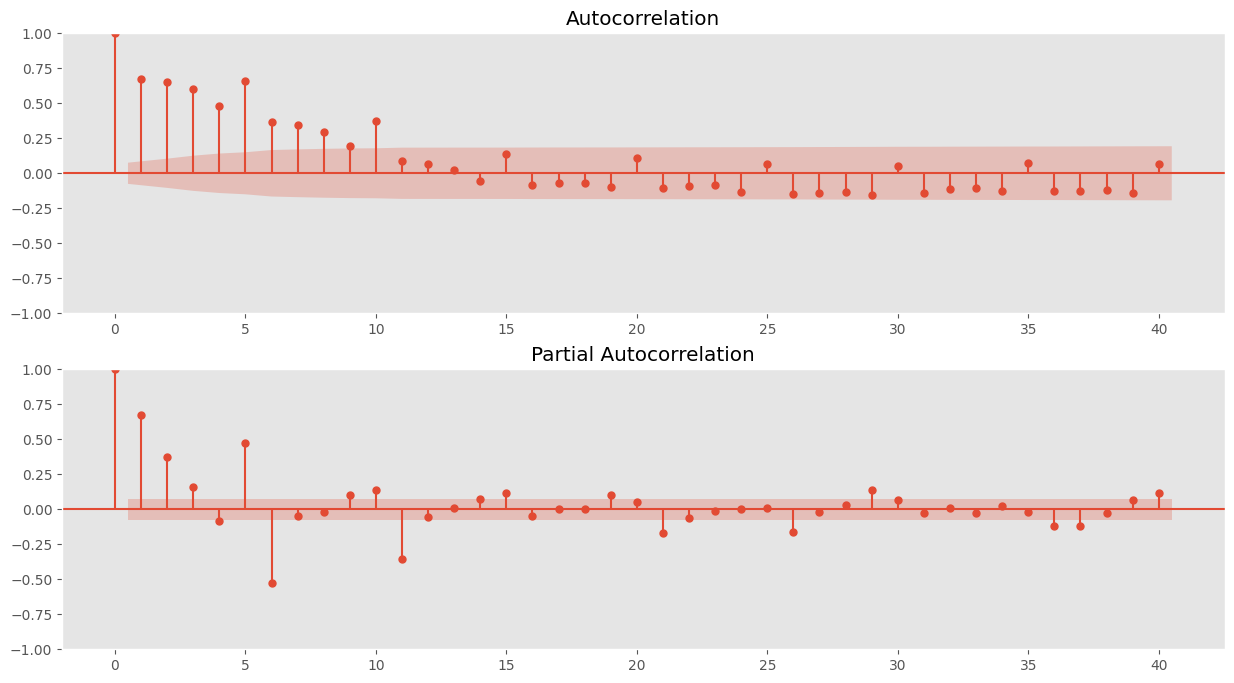

In [469]:
fig = plt.figure(figsize=(15,8))
ax1= fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_arma['unit_sales'].iloc[13:],lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_arma['unit_sales'].iloc[13:],lags=40,ax=ax2)

In [470]:
type(df_arma)


pandas.core.frame.DataFrame

In [471]:
df = df_arma['unit_sales'].squeeze()

In [472]:
type(df)

pandas.core.series.Series

In [473]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

In [474]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = r2_score(y_true,y_pred)
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2),
                       'RSquared':round(r_squared, 2)
                                             }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## ARIMA

In [490]:
df.values

array([37.        , 25.28346457, 23.875     , 17.80952381, 17.48837209,
       12.12195122, 18.63565891, 16.48780488, 12.97560976, 14.54761905,
       11.86363636, 19.74045802, 17.28571429, 14.0952381 , 14.65116279,
       11.81818182, 18.08088235, 15.4047619 , 13.18604651, 13.55813953,
       13.37209302, 25.34074074, 19.79069767, 15.11111111, 17.73809524,
       14.18604651, 21.71532847, 19.95555556, 18.125     , 16.73809524,
       16.63157895, 18.13475177, 17.22222222, 20.87234043, 19.38297872,
       15.69565217, 20.97080292, 17.04347826, 13.84782609, 15.74418605,
       11.70833333, 21.34782609, 18.02040816, 16.70454545, 16.11111111,
       13.        , 19.30985915, 19.9047619 , 13.10638298, 14.51111111,
       10.35416667, 17.58865248, 15.57446809, 14.81578947, 14.325     ,
       11.88372093, 18.27857143, 15.52173913, 11.65957447, 13.34782609,
       10.90909091, 18.32142857, 15.22727273, 12.68085106, 19.20454545,
       15.21276596, 19.02941176, 17.11111111, 13.04255319, 13.54

In [491]:
import warnings
from pandas import Series
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate the combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [492]:
# evaluate parameters
p_values = [0, 1, 1, 1,1]
d_values = range(1, 2)
q_values = range(1, 2)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [493]:
trainset.tail(12)

date
2016-12-02    16.772414
2016-12-05    12.980769
2016-12-06    14.620000
2016-12-07    14.142857
2016-12-08    10.568182
2016-12-09    14.479730
2016-12-12    13.255319
2016-12-13    10.604167
2016-12-14    11.212766
2016-12-15     9.562500
2016-12-16    14.902778
2016-12-19    13.843137
Freq: B, Name: unit_sales, dtype: float64

In [494]:
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(trainset, order = (10,0,8))
model_arima_fit = model_arima.fit()
arima_predict = model_arima_fit.predict(start=pd.to_datetime('2016-11-21'), end=pd.to_datetime('2017-08-25')
                                           ,dynamic=False)

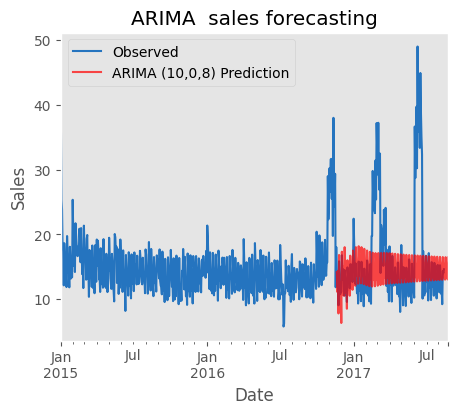

In [495]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
#rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax=ax, label='ARIMA (10,0,8) Prediction', alpha= 0.7, color='red') 
plt.title('ARIMA  sales forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [496]:
arima_results= performance(df[-200:],arima_predict)
arima_results

{'MSE': 61.59, 'RMSE': 7.85, 'MAPE': 21.46, 'RSquared': -0.17}

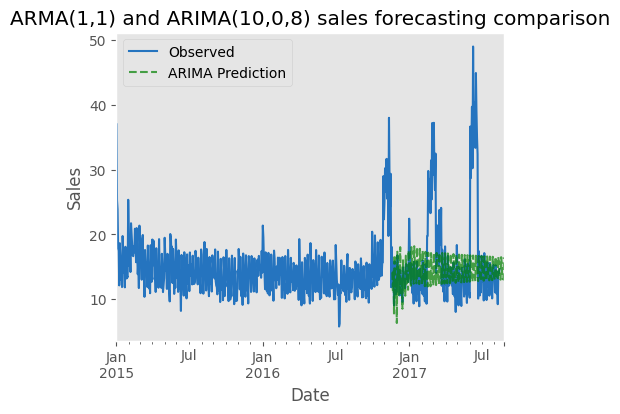

In [497]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
#rcParams['figure.figsize'] = 14, 7
#arma_predict.plot(ax=ax,label='ARMA (1,1) Prediction', linestyle= '-.', alpha= 0.7, color='r')
arima_predict.plot(ax=ax, label='ARIMA Prediction', linestyle= "--" ,alpha= 0.7, color='g')
plt.title('ARMA(1,1) and ARIMA(10,0,8) sales forecasting comparison')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [498]:
arima_predict

2016-11-21    14.137415
2016-11-22    11.096202
2016-11-23    14.361623
2016-11-24     7.784645
2016-11-25    16.817891
                ...    
2017-08-21    15.587973
2017-08-22    13.515230
2017-08-23    13.205784
2017-08-24    13.027015
2017-08-25    16.454207
Freq: B, Name: predicted_mean, Length: 200, dtype: float64

In [499]:
df[-12:]

date
2017-07-31    15.288462
2017-08-01    13.301887
2017-08-02    13.520000
2017-08-03    11.042553
2017-08-04    15.231788
2017-08-07    13.653061
2017-08-08    10.829787
2017-08-09    11.565217
2017-08-10     9.215686
2017-08-11    14.331034
2017-08-14    14.000000
2017-08-15    14.613636
Freq: B, Name: unit_sales, dtype: float64

In [500]:
!pip install pmdarima 

In [501]:
## Find optimal order
import pmdarima as pm
model_1 = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

# Print model summary
print(model_1.summary())

#best model is Fit ARIMA: ARIMA(2,0,2) and seasonal_order=(2, 1, 1, 12); AIC=2639,

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3058.698, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2888.546, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3057.083, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2958.290, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2840.514, Time=0.75 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2899.630, Time=0.86 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2798.428, Time=0.84 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2862.291, Time=0.39 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=2769.2

## SARIMA

In [502]:
#fitting model
sarima_model_1 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_1 = sarima_model_1.fit()
print(sarima_fit_1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8543      0.163     11.363      0.000       1.534       2.174
ar.L2         -0.8595      0.154     -5.593      0.000      -1.161      -0.558
ma.L1         -1.7602      0.189     -9.313      0.000      -2.131      -1.390
ma.L2          0.7314      0.134      5.450      0.000       0.468       0.994
ar.S.L12      -0.1732      0.064     -2.710      0.007      -0.298      -0.048
ar.S.L24      -0.1830      0.060     -3.075      0.002      -0.300      -0.066
ma.S.L12      -0.9945      0.389     -2.554      0.011      -1.758      -0.231
sigma2         7.5062      3.500      2.144      0.032       0.646      14.366


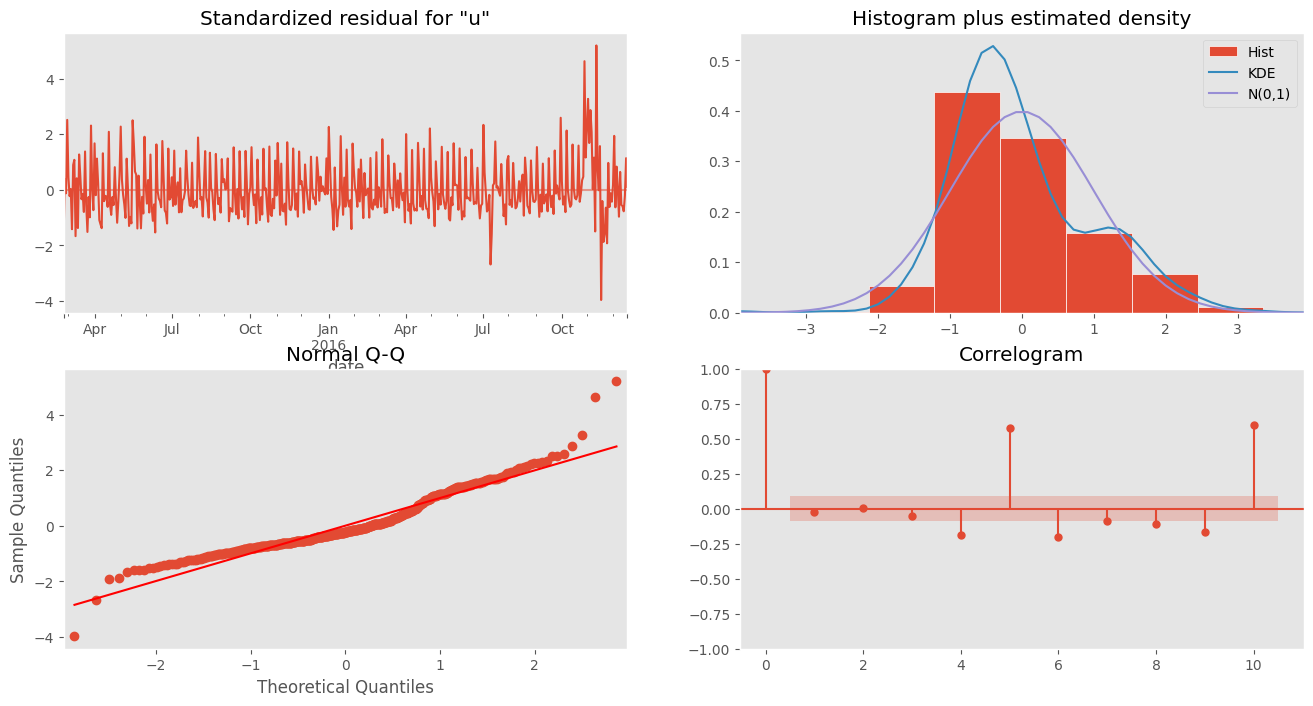

In [503]:
sarima_fit_1.plot_diagnostics(figsize=(16, 8))
plt.show()


In [504]:
df.tail

<bound method NDFrame.tail of date
2015-01-01    37.000000
2015-01-02    25.283465
2015-01-05    23.875000
2015-01-06    17.809524
2015-01-07    17.488372
                ...    
2017-08-09    11.565217
2017-08-10     9.215686
2017-08-11    14.331034
2017-08-14    14.000000
2017-08-15    14.613636
Freq: B, Name: unit_sales, Length: 684, dtype: float64>

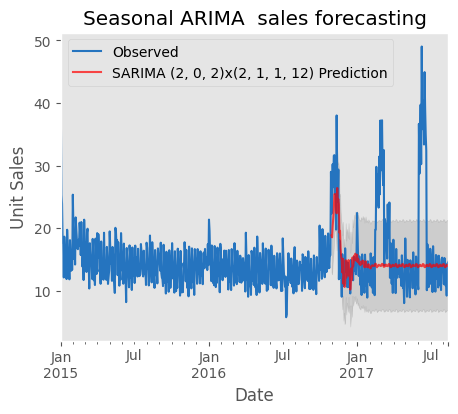

In [505]:
# One step ahead forecast
sarima_predict_1 = sarima_fit_1.get_prediction(start=pd.to_datetime('2016-10-31'), end=pd.to_datetime('2017-08-15')
                                           ,dynamic=False)
sarima_predict_conf_1 = sarima_predict_1.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
#rcParams['figure.figsize'] = 14, 7
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA (2, 0, 2)x(2, 1, 1, 12) Prediction', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_1.index,
                #lower sales
                sarima_predict_conf_1.iloc[:, 0],
                #upper sales
                sarima_predict_conf_1.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA  sales forecasting')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()

In [506]:
trainset.tail(12)

date
2016-12-02    16.772414
2016-12-05    12.980769
2016-12-06    14.620000
2016-12-07    14.142857
2016-12-08    10.568182
2016-12-09    14.479730
2016-12-12    13.255319
2016-12-13    10.604167
2016-12-14    11.212766
2016-12-15     9.562500
2016-12-16    14.902778
2016-12-19    13.843137
Freq: B, Name: unit_sales, dtype: float64

In [507]:
sarima_results=performance(df[-207:],sarima_predict_1.predicted_mean)
sarima_results

{'MSE': 65.42, 'RMSE': 8.09, 'MAPE': 24.35, 'RSquared': 0.01}

# Deep Learning

In [124]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [125]:
#pip install statsmodels
!pip install sklearn

In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib



     --------------------------------------- 10.6/10.6 MB 65.6 MB/s eta 0:00:00
     ---------------------------------------- 500.6/500.6 kB ? eta 0:00:00
     ---------------------------------------- 7.2/7.2 MB 66.0 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.4-cp39-cp39-win_amd64.whl (55 kB)
     ------------------------------------- 957.2/957.2 kB 59.2 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ---------------------------------------- 3.3/3.3 MB 105.4 MB/s eta 0:00:00


In [6]:
pip install seaborn

     ------------------------------------- 292.8/292.8 kB 18.8 MB/s eta 0:00:00



In [7]:
pip install itertools

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [142]:
df_lstm = train_subset.resample('B').mean()

In [143]:
df1 = df_lstm['unit_sales'].squeeze()

In [144]:
train1, test1 = np.array(df1[:-12]), np.array(df1[-12:])
train1= train1.reshape(-1,1)
test1= test1.reshape(-1,1)

In [ ]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train1)
train1 = scaler.transform(train1)
test1 = scaler.transform(test1)

In [149]:
n_input = 671
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train1, train1, length=n_input, batch_size=10)

## Vanilla LSTM

In [215]:
######
#set the counter to repeat
n=2
store= np.zeros((671,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(50, activation='relu', input_shape=(671, 1)))
    #Add layer
    model_vanilla.add(Dense(100, activation='relu'))
    model_vanilla.add(Dense(100, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=10)
    
    pred_list = []

    batch = train1[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list.append(model_vanilla.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df1[-n_input:].index, columns=['Prediction'])

    
    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 132735648.0000
Epoch 2/10
1/1 [==============================] - 0s 143ms/step - loss: 26748083240960.0000
Epoch 3/10
1/1 [==============================] - 0s 141ms/step - loss: 226.8840
Epoch 4/10
1/1 [==============================] - 0s 139ms/step - loss: 226.9358
Epoch 5/10
1/1 [==============================] - 0s 141ms/step - loss: 226.9784
Epoch 6/10
1/1 [==============================] - 0s 141ms/step - loss: 227.0147
Epoch 7/10
1/1 [==============================] - 0s 141ms/step - loss: 227.0461
Epoch 8/10
1/1 [==============================] - 0s 141ms/step - loss: 227.0737
Epoch 9/10
1/1 [==============================] - 0s 141ms/step - loss: 227.0980
Epoch 10/10
1/1 [==============================] - 0s 125ms/step - loss: 227.1197
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 6729826.5000
Epoch 2/10
1/1 [==============================] - 0s 141ms/step - loss: 81991856.0000
Epoch 3

In [216]:
final_vanilla= np.zeros((store.shape[0],1))

#final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):
    
    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((671,))

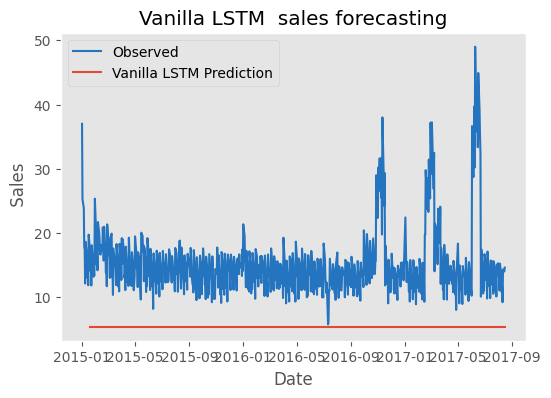

In [508]:
# report performance
rcParams['figure.figsize'] = 6, 4
# line plot of observed vs predicted
plt.plot(df1.index,df1,label="Observed",color='#2574BF')
plt.plot(df1[13:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM  sales forecasting')
plt.xlabel('Date')
plt.ylabel(' Sales')
plt.legend()
plt.show()

In [ ]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = r2_score(y_true,y_pred)
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2),
                       'RSquared':round(r_squared, 2)
                                             }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [456]:
vanilla_lstm= performance(df1[-671:],final_vanilla)
vanilla_lstm

{'MSE': 117.42, 'RMSE': 10.84, 'MAPE': 60.55, 'RSquared': -3.2}

## LSTM 4-LAYER

In [330]:
df_input_lstm = train_subset[['unit_sales']]

In [331]:
df_input_lstm 

unit_sales
date                  
2015-01-01        37.0
2015-01-02        27.0
2015-01-02        22.0
2015-01-02        92.0
2015-01-02        14.0
...                ...
2017-08-15        26.0
2017-08-15         2.0
2017-08-15        28.0
2017-08-15        28.0
2017-08-15         8.0

[46458 rows x 1 columns]

In [332]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

In [333]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input_lstm)

In [334]:
features=data_scaled
target=data_scaled[:,0]

In [335]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.06239168],
         [0.04506066]]]),
 array([0.03639515]))

In [336]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)
x_train.shape

(37166, 1)

In [337]:
win_length=2
batch_size=10
num_features=1
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [338]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(1))

In [339]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 2, 128)            66560     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 2, 128)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 2, 128)            131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 2, 128)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 2, 128)            131584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 2, 128)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 128)          

In [340]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=10,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/10
3717/3717 [==============================] - 29s 6ms/step - loss: 9.5651e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0022 - val_mean_absolute_error: 0.0249
Epoch 2/10
3717/3717 [==============================] - 22s 6ms/step - loss: 8.8598e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0022 - val_mean_absolute_error: 0.0242
Epoch 3/10
3717/3717 [==============================] - 22s 6ms/step - loss: 8.6730e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0022 - val_mean_absolute_error: 0.0242
Epoch 4/10
3717/3717 [==============================] - 22s 6ms/step - loss: 8.6178e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0022 - val_mean_absolute_error: 0.0243


In [341]:
model.evaluate_generator(test_generator, verbose=0) 

[0.0021737024653702974, 0.02430996298789978]

In [342]:
predictions=model.predict_generator(test_generator)

In [343]:
x_test[:,1:][win_length:]

array([], shape=(9290, 0), dtype=float64)

In [344]:
df_pred_lstm =pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [345]:
rev_trans=scaler.inverse_transform(df_pred_lstm)

In [346]:
df_final=df_input_lstm[predictions.shape[0]*-1:]

In [347]:
df_final['App_Pred']=rev_trans[:,0]

<AxesSubplot:xlabel='date'>

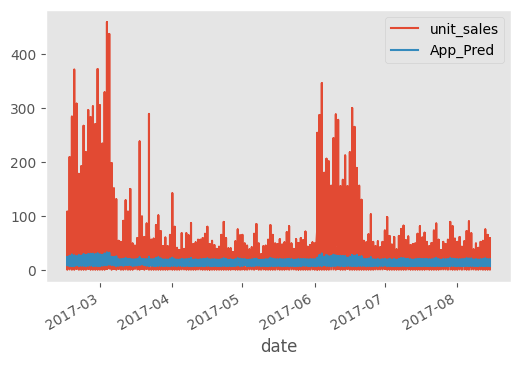

In [512]:
rcParams['figure.figsize'] = 6, 4
df_final[['unit_sales','App_Pred']].plot()

In [460]:
def rmse(x,y):
    return ((df_final[x]-df_final[y])**2).mean()**0.5
def mse(x,y):
    return ((df_final[x]-df_final[y]) ** 2).mean()
def mape(x,y):
     return np.mean(np.abs(((df_final[x]-df_final[y])) / df_final[x])) * 100
def r_sq(x,y):
    return r2_score(df_final[x],df_final[y
                                       ])

In [461]:
aa='unit_sales'
bb='App_Pred'

print('rmse is ',rmse(aa,bb))
print('mse is',mse(aa,bb))
print('mape is',mape(aa,bb))
print('R Squared is',r_sq(aa,bb))

rmse is  26.901469809050592
mse is 723.6890778872605
mape is 192.80352782059896
R Squared is 0.013511694519830697
